In [1]:
import sys
import glob
import os
import ee
import math
import random
import pandas as pd
import numpy as np
import geopandas as gp
import scipy.stats as stats

import matplotlib.pyplot as plt
import rsfuncs as rs

from scipy import stats
from scipy.signal import savgol_filter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import KFold

from pandas.tseries.offsets import MonthEnd, SemiMonthEnd
from datetime import datetime, timedelta
from datetime import datetime as dt

from keras import regularizers, optimizers
from keras.models import Sequential, load_model
from keras.layers import Dense
from keras.layers import LSTM
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.utils import to_categorical

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [10,6]

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/aakashahamed/anaconda3/envs/gis/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/a

In [2]:
# Numeric NLCD vals to class labels
nlcd= {0: "Open water",
1 : "Perennial ice/snow",
2 : "Developed",
3 : "Developed, low intensity",
4 : "Developed, medium intensity",
5 : "Developed high intensity",
6 : "Barren land (rock/sand/clay)",
7 : "Deciduous forest", 
8 : "Evergreen forest",
9 : "Mixed forest",
10 : "Dwarf scrub",
11 : "Shrub/scrub",
12 : "Grassland/herbaceous",
13 : "Sedge/herbaceous",
14 : "Lichens",
15 : "Moss",
16 : "Pasture/hay",
17 : "Cultivated crops",
18 : "Woody wetlands",
19 : "Emergent herbaceous wetlands"}


In [3]:
# Read data

In [4]:
data_dir = "../data"

states_file = gp.read_file("../shape/states.shp")
states = states_file[~states_file['STATE_ABBR'].isin(["AK", "HI", "PR", "VI"])]

site_file = gp.read_file("../shape/scan_sites.shp")
sites = site_file[~site_file['state'].isin(["AK", "HI", "PR", "VI"])]


In [5]:
# Read and format the RS data 

df = pd.read_csv("../data/all_dat_f.csv")
df.rename(columns={ df.columns[0]: "site" , df.columns[1]:"date"}, inplace = True)
df.replace([np.inf, -np.inf], np.nan, inplace = True)
df = df.set_index(pd.to_datetime(df.date))
df['date'] = pd.to_datetime(df.date)

# Remove outliers
# df = df[~(np.abs(df.psi_rz-df.psi_rz.mean()) > (df.psi_rz.std()))]

In [6]:
# Filter the data

# Drop days with 2day precip less than 1 mm
df = df[df.precip<1]

# Remove Urban Areas
df = df[df.lc_type != 2]
df = df[df.lc_type != 3]
df = df[df.lc_type != 4]
df = df[df.lc_type != 5]

# Remove sites with <10 datapoints
for i in df.site.unique():
    if len(df[df.site == i]) < 10:
        df = df[df.site != i]

# Calculate spectral indices
# df['ndvi'] = (df.B5 - df.B4) / (df.B5 + df.B4)
# df["ndmi"] = (df.B5 - df.B6) / (df.B5 + df.B6)
# df["evi"] = 2.5*(df.B5 - df.B4) / (df.B5 + 6*df.B4- 7.5*df.B2 + 1)

df['ndvi'] = (df.B5_filt - df.B4_filt) / (df.B5_filt + df.B4_filt)
df["ndmi"] = (df.B5_filt - df.B6_filt) / (df.B5_filt + df.B6_filt)
df["evi"] = 2.5*(df.B5_filt - df.B4_filt) / (df.B5_filt + 6*df.B4_filt - 7.5*df.B2_filt + 1)

# For the backscatter columns (df.vv, df.hv), delete any zeros, nans, deal with weird formatting, and calc the mean 
vv_eff = []

for i in df.vv:
    line = i.replace("[","")
    line = line.replace("]","")
    line = ' '.join(line.split())
    data = [float(i) for i in line.split(' ')]
    data = [i for i in data if i !=0.]
    vv_eff.append(np.nanmean(data))
    

hv_eff = []

for i in df.hv:
    if type(i) is float:
        hv_eff.append(np.nan)
    else:
        line = i.replace("[","")
        line = line.replace("]","")
        line = ' '.join(line.split())
        data = [float(i) for i in line.split(' ')]
        data = [i for i in data if i !=0.]
        hv_eff.append(np.nanmean(data))


df['vv'] = vv_eff
df['hv'] = hv_eff

In [7]:
# Select the filtered sites from the shapefile

In [8]:
validsites = [x for x in sites.id if int(x) in df.site.unique()]
sites = sites[sites.id.isin(validsites)]

In [9]:
# Join the scan data and rs data

# Scan join cols
join_cols = ["id","elev", "clay_fract", "silt_fract", "sand_fract", "a", "b"]
jdf = sites[join_cols]

In [10]:
df = pd.merge(df, jdf.astype(float), right_on= "id", left_on= "site", how = "inner")

### Compute the depth weighted root zone soil moisture for each site

Based on Jackson et al., 1996:

https://www.agro.uba.ar/users/sala/pdfs/063-oecol96c.pdf

Jackson, R. B., Canadell, J., Ehleringer, J. R., Mooney, H. A., Sala, O. E., & Schulze, E. D. (1996). A global analysis of root distributions for terrestrial biomes. Oecologia, 108(3), 389-411.

#### Equation 1:  $ Y =  1- \beta ^d $

Y is root density, d is depth, $\beta$ is empirical parameter

#### From table 1
grasses: $\beta$ = 0.952
trees: $\beta$ = 0.970
shrubs: $\beta$ = 0.978
...

In [11]:
def calc_y(depth,beta):
    y = 1-beta**depth
    return y

def calc_weighted_avg(ys):
    return [x/sum(ys) for x in ys]

In [12]:
# These beta values correspond to landcover types in NLCD 
beta_dict = { 
        12: 0.952,
        11: 0.978,
        17: 0.961,
        7: 0.970,
        16: 0.952,
        8: 0.970,
        6: 0.914, 
        }

In [13]:
# Now loop through each site id, read the SCAN soil moisture from data dir, compute the depth averaged SM

In [14]:
# Helper to read a SCAN site text file and return the data as a dataframe 

def read_sm_file(filename):
    with open(filename) as f:
        contents = f.readlines()

    data = []
    for line in contents:
        if line[0:1] == "#":
            continue
        else:
            data.append(line)

    headers = [x.replace("Soil Moisture Percent","smp").replace(" ","_") for x in data[0].split(",")]
    cols = [x.strip("\n").split(",") for x in data[1:]]

    df = pd.DataFrame(cols, columns = headers)
    
    return df


In [15]:
# Heres the big loop

In [16]:
# Setup the results datastructures 
spatial_stats = {}
temporal_stats = {}
out_dfs = []

for idx, row in sites.iterrows():
        
    print("Processings site no {}".format(row.id))
    
    # Get the corresponding SCAN data file from data folder
    site_id = row.id
    sm_file = [os.path.join(data_dir,x) for x in os.listdir(data_dir) if site_id in x][0]
    sm_dat = read_sm_file(sm_file)
    sm_dat['Date'] =  pd.to_datetime(sm_dat['Date'], format='%Y%m%d %H:%M')
    sm_dat.set_index('Date', inplace=True)
    
    if sm_dat.empty:
        print("no valid data")
        continue 
    
    # Rename the columns to the depths in cm (approx)
    sm_dat.rename(columns= { 
                        sm_dat.columns[0]: "5",
                        sm_dat.columns[1]: "10",
                        sm_dat.columns[2]: "20",
                        sm_dat.columns[3]: "50",
                        sm_dat.columns[4]: "100"
                        }, inplace = True)
    
    # Eliminate whitespace and drop rows with nans 
    sm_dat = sm_dat.replace(r'^\s*$', np.nan, regex=True)
    sm_dat = sm_dat.dropna()
    
    if sm_dat.empty:
        print("no valid data")
        continue 
        
    # Get the RS data for that site 
    rsdf = df[df.id == int(row.id)]
    lct = rsdf.lc_type.unique()[0]
    beta = beta_dict[lct]
    
    # Calculate the weighted sum for each row 
    was = []
    for idx, x in sm_dat.iterrows():
        depths = x.index.values
        depths = [float(x) for x in depths]
        ys = [calc_y(x,beta) for x in depths]
        wa = calc_weighted_avg(ys)
        wa = np.array(wa)
        smvals = [float(j) for j in x.values]
        weighted_sum = np.array(smvals*wa).sum()
        was.append(weighted_sum)
    
    # append the weighted sums to the dataframe 
    sm_dat['ws'] = was
    sm_dat = sm_dat.rename(columns={"5": "d5", "10": "d10", "20":"d20", "50": "d50", "100":"d100"})
    
    # Get the site specific mean and STD for all times 
    spatial_stats[row.id] = [np.mean(sm_dat.ws),np.std(sm_dat.ws)**2]

    # Get the temporal mean / std for 3 am - 7 am each day 
    opt = sm_dat[sm_dat.index.hour == 6].ws.values
    temporal_stats[row.id] = [np.mean(opt), np.std(opt)**2]
    
    # For all the dates with RS data, extract the depth averaged sm and join it to the master df
    sdf = df[df.site == int(row.id)]
    sdf.set_index(pd.to_datetime(sdf.date), inplace = True)
    dates = sdf.index
    
    rzsm = []

    for i in dates:
        starttime = i.replace(second=0, microsecond=0, minute=0, hour=3)
        endtime = starttime+timedelta(hours= 4)
        ddf = pd.DataFrame(sm_dat[starttime:endtime])
        rzsm.append(ddf)
        
    resampled = pd.concat(rzsm).resample("D").mean()
    sdf = sdf.resample("D").mean()
    
    final = pd.merge(sdf, resampled, left_index = True, right_index = True, how = "inner").dropna()
    
    out_dfs.append(final)

Processings site no 2214
no valid data
Processings site no 2215
Processings site no 2189
Processings site no 2190
Processings site no 2187
Processings site no 2183
Processings site no 2191
Processings site no 2192
Processings site no 2185
Processings site no 2184
Processings site no 2218
Processings site no 2149
Processings site no 2217
Processings site no 2186
Processings site no 2219
Processings site no 2197
Processings site no 2148
no valid data
Processings site no 674
no valid data
Processings site no 2117
Processings site no 2019
Processings site no 2121
Processings site no 581
Processings site no 2119
Processings site no 808
Processings site no 2118
Processings site no 2111
Processings site no 2069
Processings site no 2015
Processings site no 2172
Processings site no 2107
Processings site no 2168
Processings site no 2169
Processings site no 2171
Processings site no 2108
Processings site no 2216
no valid data
Processings site no 2145
Processings site no 2141
Processings site no 21

In [17]:
analysis_df = pd.concat(out_dfs)

In [18]:
analysis_df.to_csv("../data/FINAL_DATA.csv")

In [19]:
# Compile the spatial and temporal stats 

tempdf = []

for k,v in temporal_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_t'] = v[0]
    sdf['sm_var_t'] = v[1]
    tempdf.append(sdf)

spatialdf = []

for k,v in spatial_stats.items():
    sdf = sites[sites.id == k]
    sdf['sm_mean_s'] = v[0]
    sdf['sm_var_s'] = v[1]
    spatialdf.append(sdf)

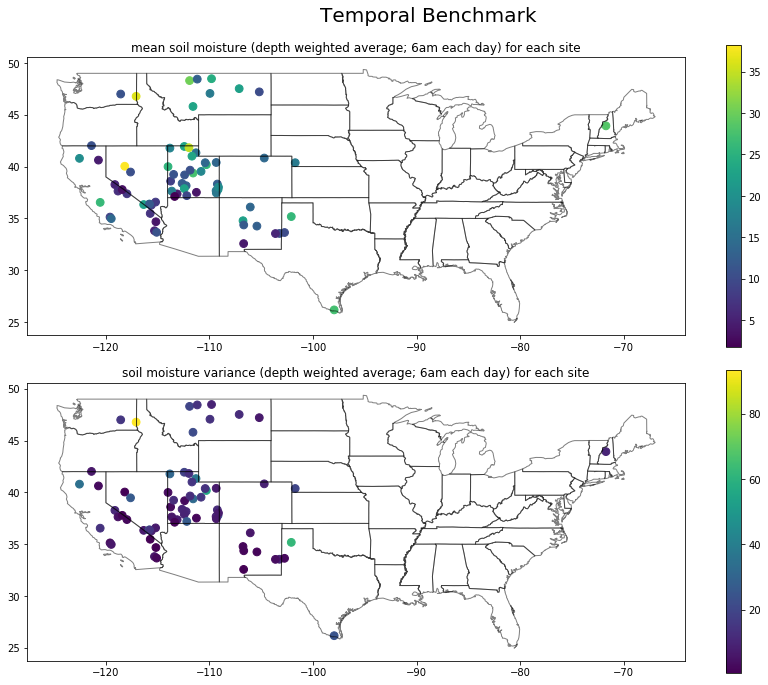

In [20]:
fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Temporal Benchmark", size = 20)

ax[0].set_title("mean soil moisture (depth weighted average; 6am each day) for each site")
pd.concat(tempdf).plot(ax = ax[0], column = "sm_mean_t",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("soil moisture variance (depth weighted average; 6am each day) for each site")
pd.concat(tempdf).plot(ax = ax[1], column = "sm_var_t",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

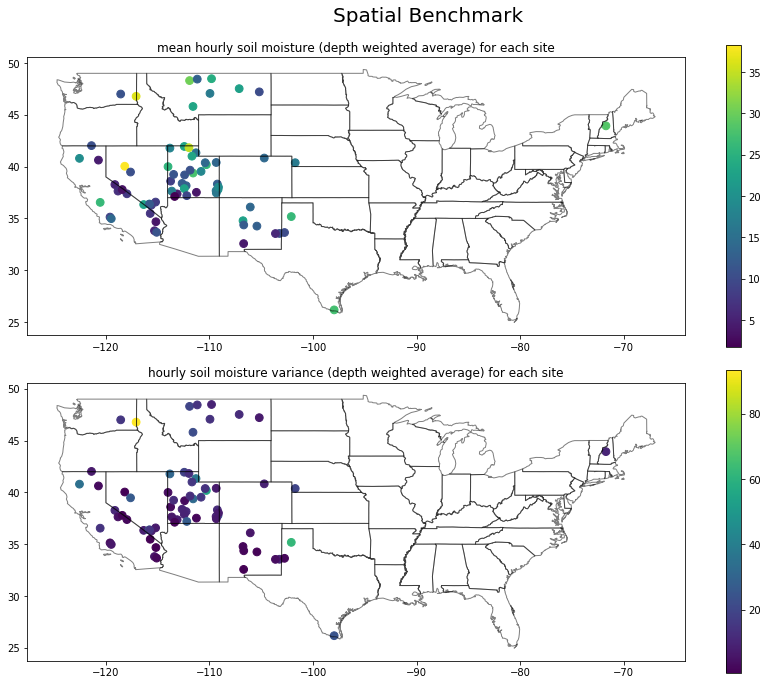

In [21]:
fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Spatial Benchmark", size = 20)

ax[0].set_title("mean hourly soil moisture (depth weighted average) for each site")
pd.concat(spatialdf).plot(ax = ax[0], column = "sm_mean_s",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("hourly soil moisture variance (depth weighted average) for each site")
pd.concat(spatialdf).plot(ax = ax[1], column = "sm_var_s",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

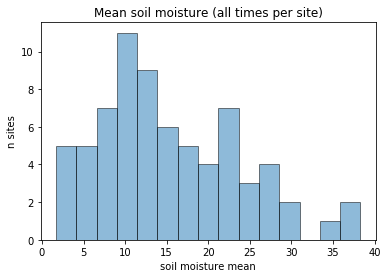

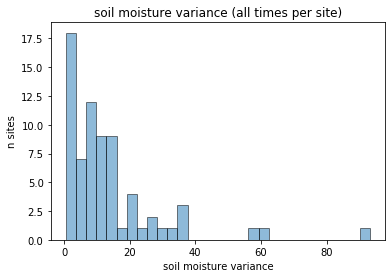

In [22]:
plt.hist(pd.concat(tempdf).sm_mean_t.values, bins = 15, alpha = 0.5, edgecolor='black',)
plt.title("Mean soil moisture (all times per site)")
plt.xlabel("soil moisture mean")
plt.ylabel("n sites")
plt.show()
plt.hist(pd.concat(tempdf).sm_var_t.values, bins = 30, alpha = 0.5, edgecolor='black',)
plt.title("soil moisture variance (all times per site)")
plt.xlabel("soil moisture variance")
plt.ylabel("n sites")
plt.show()

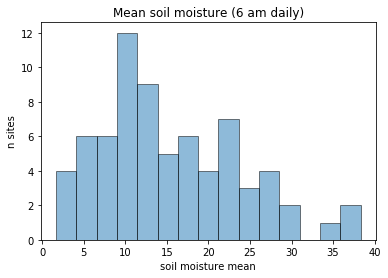

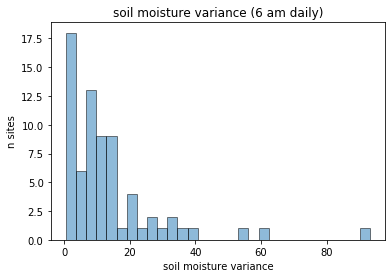

In [24]:
plt.hist(pd.concat(spatialdf).sm_mean_s.values, bins = 15, alpha = 0.5, edgecolor='black',)
plt.title("Mean soil moisture (6 am daily)")
plt.xlabel("soil moisture mean")
plt.ylabel("n sites")
plt.show()
plt.hist(pd.concat(spatialdf).sm_var_s.values, bins = 30, alpha = 0.5, edgecolor='black',)
plt.title("soil moisture variance (6 am daily)")
plt.xlabel("soil moisture variance")
plt.ylabel("n sites")
plt.show()

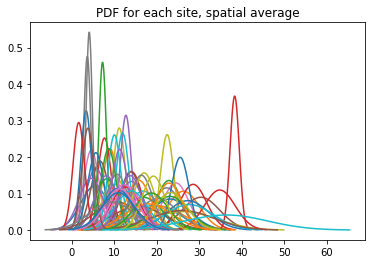

Text(0.5, 1.0, 'PDF for each site, temporal average')

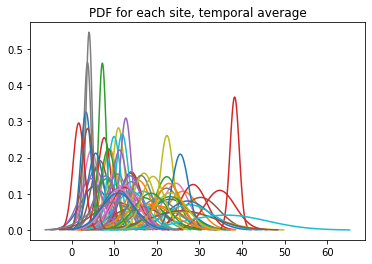

In [25]:
for k,v in spatial_stats.items():
    mu = v[0]
    var = v[1]
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.title("PDF for each site, spatial average")
plt.show()

for k,v in temporal_stats.items():
    mu = v[0]
    var = v[1]
    sigma = math.sqrt(var)
    x = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
    plt.plot(x, stats.norm.pdf(x, mu, sigma))

plt.title("PDF for each site, temporal average")

In [26]:
meandiff = {}
vardiff = {}
for k,v in spatial_stats.items():
    meandiff[k] = (v[0] - temporal_stats[k][0]) * 100
    vardiff[k] = (v[1] - temporal_stats[k][1]) * 100

In [27]:
mean_df = []

for k,v in meandiff.items():
    sdf = sites[sites.id == k]
    sdf['meandiff'] = v
    mean_df.append(sdf)

In [28]:
var_df = []

for k,v in vardiff.items():
    sdf = sites[sites.id == k]
    sdf['vardiff'] = v
    var_df.append(sdf)

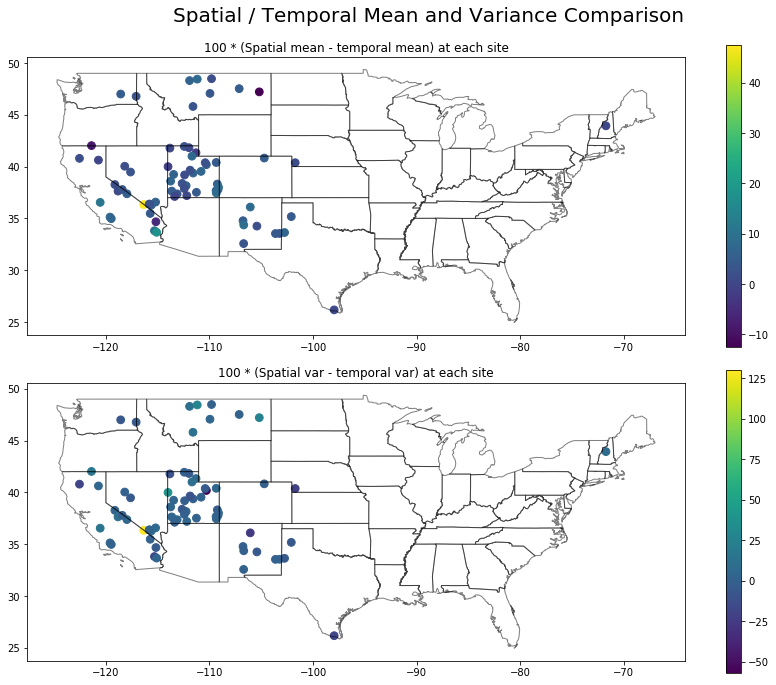

In [29]:
pd.concat(mean_df)
pd.concat(var_df)

fig, ax = plt.subplots(nrows = 2,figsize = (12,10))

fig.suptitle("Spatial / Temporal Mean and Variance Comparison", size = 20)

ax[0].set_title("100 * (Spatial mean - temporal mean) at each site")
pd.concat(mean_df).plot(ax = ax[0], column = "meandiff",markersize = 60, legend = True)
states.plot(ax = ax[0], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

ax[1].set_title("100 * (Spatial var - temporal var) at each site")
pd.concat(var_df).plot(ax = ax[1], column = "vardiff",markersize = 60, legend = True)
states.plot(ax = ax[1], color = "none", edgecolor = "black", alpha = 0.5,  linewidth = 1)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [30]:
# Setup for the LSTM 

In [31]:
analysis_df.drop(["id"], axis = 1, inplace = True)
df = analysis_df.copy()

In [32]:
# Drop nonconsecutive rows 

t = df.copy()

filtered = []

for i in t.site.unique():
    sdf = t[t.site==i]
    
    for i in sdf.index:
        begin = i
        end = begin + pd.Timedelta(days=12)
        temp = sdf[begin:end]
        num_points = len(temp)
        if num_points<1:
            print(t)
        else:
            filtered.append(temp)

filt = pd.concat(filtered).dropna()


In [33]:
df = filt.copy()

df = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()

In [34]:
# Drop the non interpolated landsat bands
df.drop(["B1", "B2", "B3", "B4", "B5", "B6", "B7"], axis = 1,inplace = True)
df.rename(columns={'B1_filt': 'B1', 'B2_filt': 'B2','B3_filt': 'B3','B4_filt': 'B4','B5_filt': 'B5','B6_filt': 'B6','B7_filt': 'B7'}, inplace=True)

In [35]:
# One hot encode the landcover types *** figure this out
# df = df.lc_type.astype(str)
one_hot = pd.get_dummies(df.lc_type, drop_first=True )
rdf = pd.concat([df, one_hot], axis = 1)
rdf = rdf.drop(["lc_type"], axis = 1)
# df = rdf.reset_index(level='site')
df = rdf.dropna()
df.columns = df.columns.map(str)

In [36]:
# Add the time lagged predictors 
s1 = df.groupby(level="site").shift(1)
# s1 = df.groupby("site").shift(1)
df1 = df.join(s1.rename(columns=lambda x: x+"_t1"))

s2 = df.groupby(level="site").shift(2)
# s2 = df.groupby("site").shift(2)
df2 = df1.join(s2.rename(columns=lambda x: x+"_t2"))

df3 = df2.copy()

In [37]:
dropstrs = ['site','precip', 'rzsm', 'ssm', 'psi_rz', "psi_s", "ws_"]
dropcols = []

for i in df3.columns:
    for x in dropstrs:
        if x in i:
            dropcols.append(i)
            
df3 = df3.drop(dropcols, axis = 1)
# df = df3.dropna()

In [38]:
# Reset the index and drop nans 
df = df3.reset_index(level='site')
df = df.dropna()

In [42]:
# Modeling options

EPOCHS = 100
BATCHSIZE = 50
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l1(0.00005)
Breg = regularizers.l2(0.001)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

def build_model(input_shape):
    # make the model 
    model = Sequential()
    
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(10, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,bias_regularizer= Breg))

    model.add(Dense(1))
    model.compile(loss=LOSS, optimizer= "Nadam",
                  metrics=['mse'])
    
    return model


In [43]:
out = {"train_preds":[], # rs
       "test_preds":[], # wells
       "train_act":[], # c2vsim
       "test_act":[]  # grace 
        }

Processing 2169.0
Train on 2668 samples, validate on 51 samples
Epoch 1/500
 - 1s - loss: 1.0330 - mse: 1.0031 - val_loss: 0.7822 - val_mse: 0.7524
Epoch 2/500
 - 0s - loss: 1.0288 - mse: 0.9990 - val_loss: 0.7822 - val_mse: 0.7526
Epoch 3/500
 - 0s - loss: 1.0254 - mse: 0.9958 - val_loss: 0.7805 - val_mse: 0.7511
Epoch 4/500
 - 0s - loss: 1.0214 - mse: 0.9920 - val_loss: 0.7761 - val_mse: 0.7469
Epoch 5/500
 - 0s - loss: 1.0174 - mse: 0.9882 - val_loss: 0.7726 - val_mse: 0.7435
Epoch 6/500
 - 0s - loss: 1.0124 - mse: 0.9833 - val_loss: 0.7597 - val_mse: 0.7308
Epoch 7/500
 - 0s - loss: 1.0060 - mse: 0.9772 - val_loss: 0.7630 - val_mse: 0.7343
Epoch 8/500
 - 0s - loss: 0.9972 - mse: 0.9685 - val_loss: 0.7559 - val_mse: 0.7274
Epoch 9/500
 - 0s - loss: 0.9866 - mse: 0.9581 - val_loss: 0.7496 - val_mse: 0.7212
Epoch 10/500
 - 0s - loss: 0.9711 - mse: 0.9428 - val_loss: 0.7373 - val_mse: 0.7091
Epoch 11/500
 - 0s - loss: 0.9548 - mse: 0.9266 - val_loss: 0.7105 - val_mse: 0.6824
Epoch 12/5

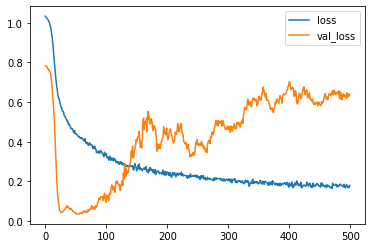

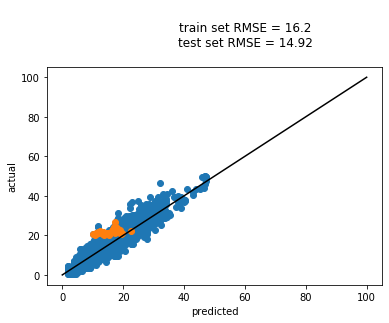

Processing 2141.0
Train on 2673 samples, validate on 46 samples
Epoch 1/500
 - 1s - loss: 1.0429 - mse: 1.0129 - val_loss: 0.8425 - val_mse: 0.8128
Epoch 2/500
 - 0s - loss: 1.0380 - mse: 1.0082 - val_loss: 0.8453 - val_mse: 0.8157
Epoch 3/500
 - 0s - loss: 1.0342 - mse: 1.0046 - val_loss: 0.8407 - val_mse: 0.8112
Epoch 4/500
 - 0s - loss: 1.0311 - mse: 1.0016 - val_loss: 0.8340 - val_mse: 0.8048
Epoch 5/500
 - 0s - loss: 1.0275 - mse: 0.9983 - val_loss: 0.8388 - val_mse: 0.8098
Epoch 6/500
 - 0s - loss: 1.0232 - mse: 0.9942 - val_loss: 0.8350 - val_mse: 0.8061
Epoch 7/500
 - 0s - loss: 1.0169 - mse: 0.9881 - val_loss: 0.8382 - val_mse: 0.8095
Epoch 8/500
 - 0s - loss: 1.0089 - mse: 0.9803 - val_loss: 0.8420 - val_mse: 0.8135
Epoch 9/500
 - 0s - loss: 0.9997 - mse: 0.9712 - val_loss: 0.8385 - val_mse: 0.8102
Epoch 10/500
 - 0s - loss: 0.9883 - mse: 0.9600 - val_loss: 0.8385 - val_mse: 0.8104
Epoch 11/500
 - 0s - loss: 0.9704 - mse: 0.9422 - val_loss: 0.8449 - val_mse: 0.8169
Epoch 12/5

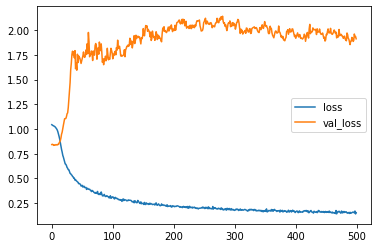

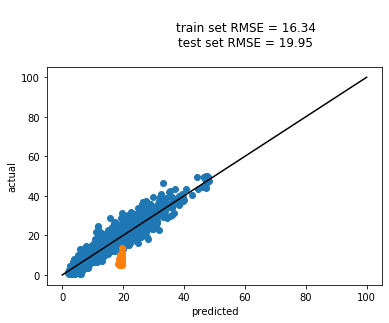

Processing 2163.0
Train on 2672 samples, validate on 47 samples
Epoch 1/500
 - 1s - loss: 1.0285 - mse: 0.9985 - val_loss: 0.5253 - val_mse: 0.4955
Epoch 2/500
 - 0s - loss: 1.0243 - mse: 0.9946 - val_loss: 0.5225 - val_mse: 0.4929
Epoch 3/500
 - 0s - loss: 1.0203 - mse: 0.9908 - val_loss: 0.5292 - val_mse: 0.4998
Epoch 4/500
 - 0s - loss: 1.0169 - mse: 0.9875 - val_loss: 0.5361 - val_mse: 0.5069
Epoch 5/500
 - 0s - loss: 1.0123 - mse: 0.9831 - val_loss: 0.5331 - val_mse: 0.5040
Epoch 6/500
 - 0s - loss: 1.0065 - mse: 0.9775 - val_loss: 0.5293 - val_mse: 0.5004
Epoch 7/500
 - 0s - loss: 0.9991 - mse: 0.9702 - val_loss: 0.5336 - val_mse: 0.5049
Epoch 8/500
 - 0s - loss: 0.9899 - mse: 0.9613 - val_loss: 0.5409 - val_mse: 0.5123
Epoch 9/500
 - 0s - loss: 0.9773 - mse: 0.9488 - val_loss: 0.5454 - val_mse: 0.5170
Epoch 10/500
 - 0s - loss: 0.9615 - mse: 0.9332 - val_loss: 0.5585 - val_mse: 0.5303
Epoch 11/500
 - 0s - loss: 0.9429 - mse: 0.9147 - val_loss: 0.5615 - val_mse: 0.5334
Epoch 12/5

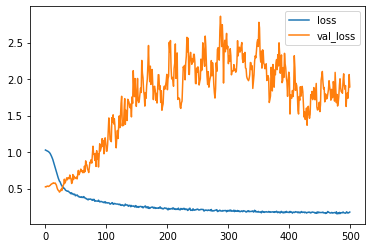

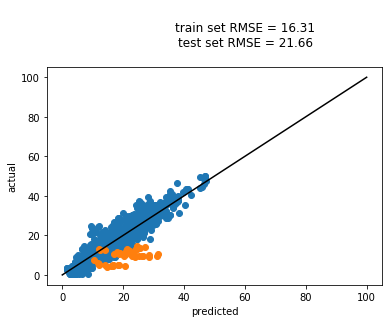

Processing 2157.0
Train on 2673 samples, validate on 46 samples
Epoch 1/500
 - 2s - loss: 1.0161 - mse: 0.9862 - val_loss: 0.7610 - val_mse: 0.7312
Epoch 2/500
 - 0s - loss: 1.0091 - mse: 0.9793 - val_loss: 0.7492 - val_mse: 0.7196
Epoch 3/500
 - 0s - loss: 1.0023 - mse: 0.9727 - val_loss: 0.7370 - val_mse: 0.7075
Epoch 4/500
 - 0s - loss: 0.9942 - mse: 0.9648 - val_loss: 0.7336 - val_mse: 0.7043
Epoch 5/500
 - 0s - loss: 0.9847 - mse: 0.9555 - val_loss: 0.7147 - val_mse: 0.6855
Epoch 6/500
 - 0s - loss: 0.9745 - mse: 0.9454 - val_loss: 0.7074 - val_mse: 0.6785
Epoch 7/500
 - 0s - loss: 0.9640 - mse: 0.9351 - val_loss: 0.6804 - val_mse: 0.6516
Epoch 8/500
 - 0s - loss: 0.9492 - mse: 0.9205 - val_loss: 0.6634 - val_mse: 0.6347
Epoch 9/500
 - 0s - loss: 0.9340 - mse: 0.9054 - val_loss: 0.6417 - val_mse: 0.6132
Epoch 10/500
 - 0s - loss: 0.9160 - mse: 0.8875 - val_loss: 0.6108 - val_mse: 0.5824
Epoch 11/500
 - 0s - loss: 0.8940 - mse: 0.8657 - val_loss: 0.5866 - val_mse: 0.5583
Epoch 12/5

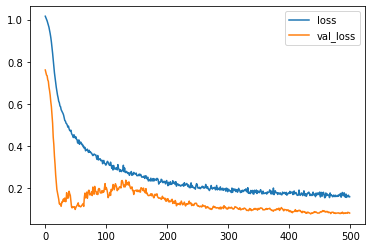

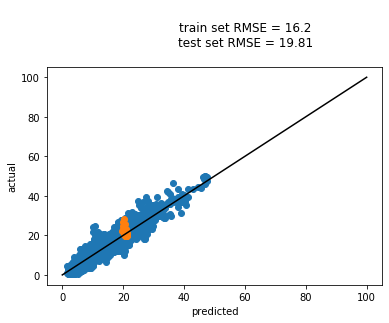

Processing 2158.0
Train on 2682 samples, validate on 37 samples
Epoch 1/500
 - 2s - loss: 1.0242 - mse: 0.9942 - val_loss: 1.9128 - val_mse: 1.8830
Epoch 2/500
 - 0s - loss: 1.0148 - mse: 0.9850 - val_loss: 1.9058 - val_mse: 1.8762
Epoch 3/500
 - 0s - loss: 1.0097 - mse: 0.9801 - val_loss: 1.8733 - val_mse: 1.8438
Epoch 4/500
 - 0s - loss: 1.0009 - mse: 0.9715 - val_loss: 1.8545 - val_mse: 1.8252
Epoch 5/500
 - 0s - loss: 0.9914 - mse: 0.9621 - val_loss: 1.8197 - val_mse: 1.7906
Epoch 6/500
 - 0s - loss: 0.9805 - mse: 0.9514 - val_loss: 1.7890 - val_mse: 1.7601
Epoch 7/500
 - 0s - loss: 0.9676 - mse: 0.9387 - val_loss: 1.7619 - val_mse: 1.7331
Epoch 8/500
 - 0s - loss: 0.9531 - mse: 0.9244 - val_loss: 1.7180 - val_mse: 1.6894
Epoch 9/500
 - 0s - loss: 0.9375 - mse: 0.9088 - val_loss: 1.6680 - val_mse: 1.6395
Epoch 10/500
 - 0s - loss: 0.9199 - mse: 0.8914 - val_loss: 1.6112 - val_mse: 1.5828
Epoch 11/500
 - 0s - loss: 0.8994 - mse: 0.8710 - val_loss: 1.5220 - val_mse: 1.4937
Epoch 12/5

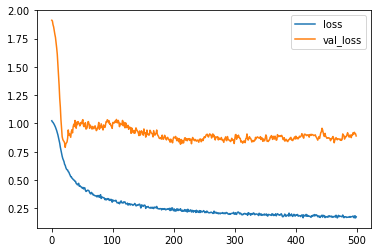

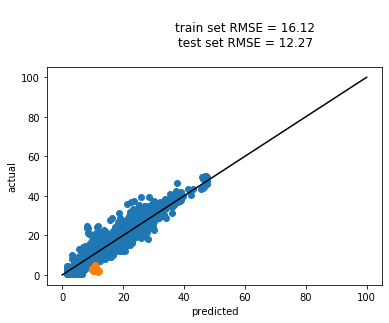

Processing 2190.0
Train on 2715 samples, validate on 4 samples
Epoch 1/500
 - 2s - loss: 1.0338 - mse: 1.0039 - val_loss: 1.1449 - val_mse: 1.1152
Epoch 2/500
 - 0s - loss: 1.0278 - mse: 0.9981 - val_loss: 1.1372 - val_mse: 1.1076
Epoch 3/500
 - 0s - loss: 1.0245 - mse: 0.9950 - val_loss: 1.1477 - val_mse: 1.1183
Epoch 4/500
 - 0s - loss: 1.0199 - mse: 0.9905 - val_loss: 1.1390 - val_mse: 1.1097
Epoch 5/500
 - 0s - loss: 1.0149 - mse: 0.9857 - val_loss: 1.1426 - val_mse: 1.1136
Epoch 6/500
 - 0s - loss: 1.0083 - mse: 0.9792 - val_loss: 1.1619 - val_mse: 1.1330
Epoch 7/500
 - 0s - loss: 1.0008 - mse: 0.9719 - val_loss: 1.1736 - val_mse: 1.1449
Epoch 8/500
 - 0s - loss: 0.9910 - mse: 0.9623 - val_loss: 1.1818 - val_mse: 1.1533
Epoch 9/500
 - 0s - loss: 0.9793 - mse: 0.9508 - val_loss: 1.2145 - val_mse: 1.1861
Epoch 10/500
 - 0s - loss: 0.9639 - mse: 0.9355 - val_loss: 1.2323 - val_mse: 1.2041
Epoch 11/500
 - 0s - loss: 0.9467 - mse: 0.9185 - val_loss: 1.2717 - val_mse: 1.2437
Epoch 12/50

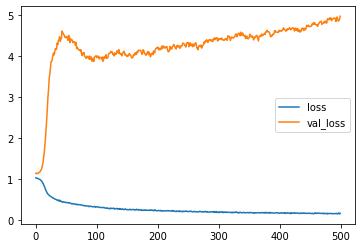

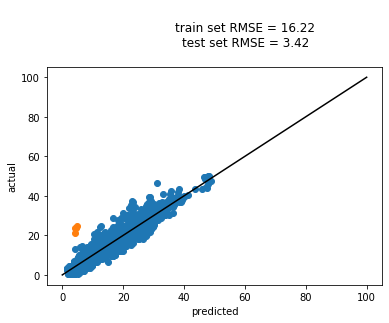

Processing 2217.0
Train on 2682 samples, validate on 37 samples
Epoch 1/500
 - 2s - loss: 1.0114 - mse: 0.9814 - val_loss: 2.6790 - val_mse: 2.6492
Epoch 2/500
 - 0s - loss: 1.0030 - mse: 0.9732 - val_loss: 2.6585 - val_mse: 2.6289
Epoch 3/500
 - 0s - loss: 0.9956 - mse: 0.9660 - val_loss: 2.6456 - val_mse: 2.6161
Epoch 4/500
 - 0s - loss: 0.9864 - mse: 0.9569 - val_loss: 2.6203 - val_mse: 2.5910
Epoch 5/500
 - 0s - loss: 0.9755 - mse: 0.9462 - val_loss: 2.6179 - val_mse: 2.5887
Epoch 6/500
 - 0s - loss: 0.9642 - mse: 0.9350 - val_loss: 2.5836 - val_mse: 2.5545
Epoch 7/500
 - 0s - loss: 0.9503 - mse: 0.9212 - val_loss: 2.5459 - val_mse: 2.5170
Epoch 8/500
 - 0s - loss: 0.9321 - mse: 0.9032 - val_loss: 2.5084 - val_mse: 2.4796
Epoch 9/500
 - 0s - loss: 0.9106 - mse: 0.8818 - val_loss: 2.4738 - val_mse: 2.4451
Epoch 10/500
 - 0s - loss: 0.8866 - mse: 0.8579 - val_loss: 2.3778 - val_mse: 2.3492
Epoch 11/500
 - 0s - loss: 0.8577 - mse: 0.8291 - val_loss: 2.2856 - val_mse: 2.2571
Epoch 12/5

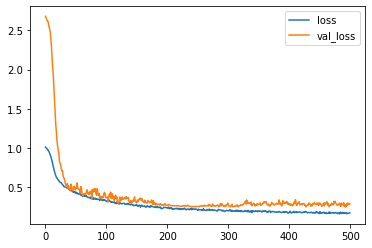

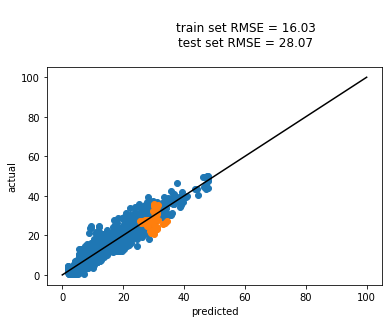

Processing 808.0
Train on 2671 samples, validate on 48 samples
Epoch 1/500
 - 2s - loss: 1.0155 - mse: 0.9855 - val_loss: 1.7157 - val_mse: 1.6859
Epoch 2/500
 - 0s - loss: 1.0079 - mse: 0.9781 - val_loss: 1.7088 - val_mse: 1.6792
Epoch 3/500
 - 0s - loss: 0.9994 - mse: 0.9698 - val_loss: 1.7169 - val_mse: 1.6875
Epoch 4/500
 - 0s - loss: 0.9923 - mse: 0.9628 - val_loss: 1.6982 - val_mse: 1.6690
Epoch 5/500
 - 0s - loss: 0.9840 - mse: 0.9548 - val_loss: 1.6870 - val_mse: 1.6579
Epoch 6/500
 - 0s - loss: 0.9703 - mse: 0.9412 - val_loss: 1.6818 - val_mse: 1.6528
Epoch 7/500
 - 0s - loss: 0.9573 - mse: 0.9284 - val_loss: 1.6957 - val_mse: 1.6668
Epoch 8/500
 - 0s - loss: 0.9451 - mse: 0.9163 - val_loss: 1.6983 - val_mse: 1.6696
Epoch 9/500
 - 0s - loss: 0.9265 - mse: 0.8978 - val_loss: 1.6946 - val_mse: 1.6660
Epoch 10/500
 - 0s - loss: 0.9055 - mse: 0.8770 - val_loss: 1.6822 - val_mse: 1.6537
Epoch 11/500
 - 0s - loss: 0.8840 - mse: 0.8556 - val_loss: 1.6444 - val_mse: 1.6160
Epoch 12/50

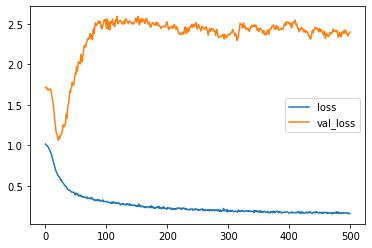

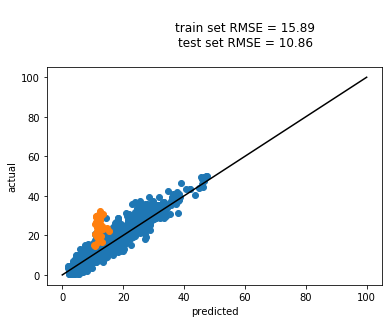

Processing 2186.0
Train on 2714 samples, validate on 5 samples
Epoch 1/500
 - 2s - loss: 1.0293 - mse: 0.9993 - val_loss: 0.7904 - val_mse: 0.7606
Epoch 2/500
 - 0s - loss: 1.0244 - mse: 0.9947 - val_loss: 0.7830 - val_mse: 0.7534
Epoch 3/500
 - 0s - loss: 1.0195 - mse: 0.9899 - val_loss: 0.7853 - val_mse: 0.7559
Epoch 4/500
 - 0s - loss: 1.0146 - mse: 0.9852 - val_loss: 0.7658 - val_mse: 0.7365
Epoch 5/500
 - 0s - loss: 1.0076 - mse: 0.9784 - val_loss: 0.7588 - val_mse: 0.7297
Epoch 6/500
 - 0s - loss: 1.0010 - mse: 0.9719 - val_loss: 0.7387 - val_mse: 0.7098
Epoch 7/500
 - 0s - loss: 0.9891 - mse: 0.9602 - val_loss: 0.7207 - val_mse: 0.6919
Epoch 8/500
 - 0s - loss: 0.9769 - mse: 0.9481 - val_loss: 0.6849 - val_mse: 0.6563
Epoch 9/500
 - 0s - loss: 0.9605 - mse: 0.9319 - val_loss: 0.6456 - val_mse: 0.6172
Epoch 10/500
 - 0s - loss: 0.9428 - mse: 0.9143 - val_loss: 0.5893 - val_mse: 0.5610
Epoch 11/500
 - 0s - loss: 0.9181 - mse: 0.8898 - val_loss: 0.5250 - val_mse: 0.4968
Epoch 12/50

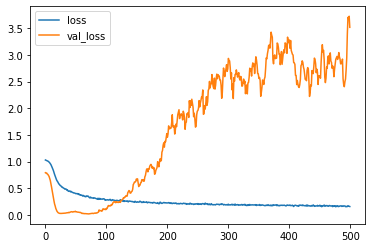

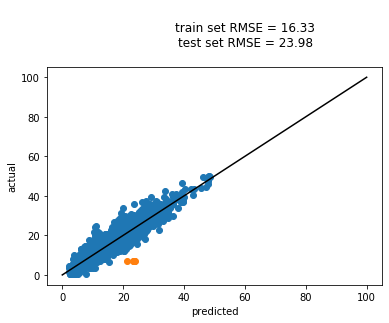

Processing 2171.0
Train on 2699 samples, validate on 20 samples
Epoch 1/500
 - 2s - loss: 1.0324 - mse: 1.0024 - val_loss: 0.1974 - val_mse: 0.1676
Epoch 2/500
 - 0s - loss: 1.0270 - mse: 0.9972 - val_loss: 0.1985 - val_mse: 0.1689
Epoch 3/500
 - 0s - loss: 1.0216 - mse: 0.9921 - val_loss: 0.1997 - val_mse: 0.1702
Epoch 4/500
 - 0s - loss: 1.0160 - mse: 0.9865 - val_loss: 0.1947 - val_mse: 0.1654
Epoch 5/500
 - 0s - loss: 1.0084 - mse: 0.9791 - val_loss: 0.1962 - val_mse: 0.1671
Epoch 6/500
 - 0s - loss: 0.9992 - mse: 0.9701 - val_loss: 0.1910 - val_mse: 0.1620
Epoch 7/500
 - 0s - loss: 0.9897 - mse: 0.9608 - val_loss: 0.1907 - val_mse: 0.1620
Epoch 8/500
 - 0s - loss: 0.9747 - mse: 0.9459 - val_loss: 0.1877 - val_mse: 0.1591
Epoch 9/500
 - 0s - loss: 0.9571 - mse: 0.9286 - val_loss: 0.1911 - val_mse: 0.1627
Epoch 10/500
 - 0s - loss: 0.9367 - mse: 0.9083 - val_loss: 0.1903 - val_mse: 0.1620
Epoch 11/500
 - 0s - loss: 0.9094 - mse: 0.8811 - val_loss: 0.1981 - val_mse: 0.1699
Epoch 12/5

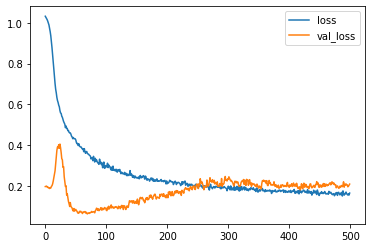

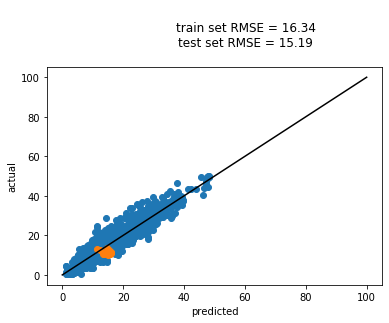

Processing 2149.0
Train on 2673 samples, validate on 46 samples
Epoch 1/500
 - 2s - loss: 1.0064 - mse: 0.9764 - val_loss: 1.6438 - val_mse: 1.6140
Epoch 2/500
 - 0s - loss: 0.9997 - mse: 0.9699 - val_loss: 1.6047 - val_mse: 1.5751
Epoch 3/500
 - 0s - loss: 0.9912 - mse: 0.9616 - val_loss: 1.5563 - val_mse: 1.5269
Epoch 4/500
 - 0s - loss: 0.9827 - mse: 0.9533 - val_loss: 1.5085 - val_mse: 1.4792
Epoch 5/500
 - 0s - loss: 0.9704 - mse: 0.9412 - val_loss: 1.4499 - val_mse: 1.4208
Epoch 6/500
 - 0s - loss: 0.9580 - mse: 0.9289 - val_loss: 1.3928 - val_mse: 1.3638
Epoch 7/500
 - 0s - loss: 0.9397 - mse: 0.9107 - val_loss: 1.3093 - val_mse: 1.2805
Epoch 8/500
 - 0s - loss: 0.9197 - mse: 0.8909 - val_loss: 1.2328 - val_mse: 1.2041
Epoch 9/500
 - 0s - loss: 0.8939 - mse: 0.8653 - val_loss: 1.1250 - val_mse: 1.0964
Epoch 10/500
 - 0s - loss: 0.8664 - mse: 0.8378 - val_loss: 1.0137 - val_mse: 0.9853
Epoch 11/500
 - 0s - loss: 0.8351 - mse: 0.8067 - val_loss: 0.9203 - val_mse: 0.8919
Epoch 12/5

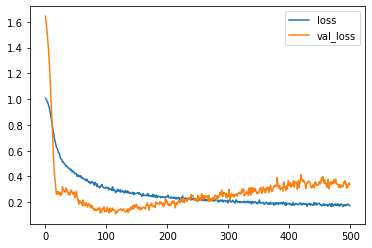

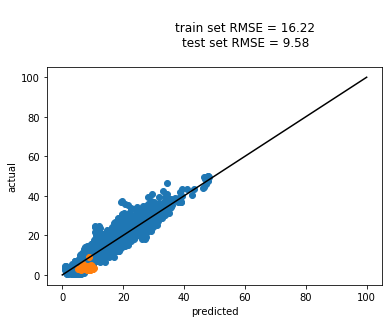

Processing 2154.0
Train on 2664 samples, validate on 55 samples
Epoch 1/500
 - 3s - loss: 1.0270 - mse: 0.9970 - val_loss: 0.1468 - val_mse: 0.1170
Epoch 2/500
 - 0s - loss: 1.0198 - mse: 0.9901 - val_loss: 0.1494 - val_mse: 0.1198
Epoch 3/500
 - 0s - loss: 1.0140 - mse: 0.9844 - val_loss: 0.1544 - val_mse: 0.1250
Epoch 4/500
 - 0s - loss: 1.0071 - mse: 0.9777 - val_loss: 0.1585 - val_mse: 0.1292
Epoch 5/500
 - 0s - loss: 0.9985 - mse: 0.9693 - val_loss: 0.1604 - val_mse: 0.1313
Epoch 6/500
 - 0s - loss: 0.9872 - mse: 0.9581 - val_loss: 0.1682 - val_mse: 0.1393
Epoch 7/500
 - 0s - loss: 0.9732 - mse: 0.9443 - val_loss: 0.1774 - val_mse: 0.1486
Epoch 8/500
 - 0s - loss: 0.9583 - mse: 0.9296 - val_loss: 0.1841 - val_mse: 0.1555
Epoch 9/500
 - 0s - loss: 0.9384 - mse: 0.9098 - val_loss: 0.1982 - val_mse: 0.1697
Epoch 10/500
 - 0s - loss: 0.9171 - mse: 0.8886 - val_loss: 0.2124 - val_mse: 0.1840
Epoch 11/500
 - 0s - loss: 0.8911 - mse: 0.8627 - val_loss: 0.2430 - val_mse: 0.2147
Epoch 12/5

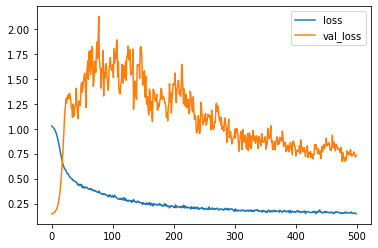

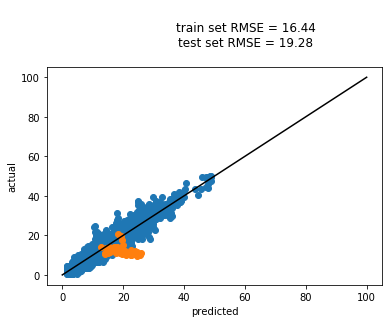

Processing 2198.0
Train on 2680 samples, validate on 39 samples
Epoch 1/500
 - 2s - loss: 1.0479 - mse: 1.0180 - val_loss: 8.8768 - val_mse: 8.8470
Epoch 2/500
 - 0s - loss: 1.0394 - mse: 1.0097 - val_loss: 8.8309 - val_mse: 8.8013
Epoch 3/500
 - 0s - loss: 1.0346 - mse: 1.0050 - val_loss: 8.8074 - val_mse: 8.7780
Epoch 4/500
 - 0s - loss: 1.0269 - mse: 0.9975 - val_loss: 8.7719 - val_mse: 8.7427
Epoch 5/500
 - 0s - loss: 1.0195 - mse: 0.9902 - val_loss: 8.7029 - val_mse: 8.6738
Epoch 6/500
 - 0s - loss: 1.0104 - mse: 0.9813 - val_loss: 8.6494 - val_mse: 8.6205
Epoch 7/500
 - 0s - loss: 0.9997 - mse: 0.9708 - val_loss: 8.6034 - val_mse: 8.5746
Epoch 8/500
 - 0s - loss: 0.9867 - mse: 0.9580 - val_loss: 8.4791 - val_mse: 8.4505
Epoch 9/500
 - 0s - loss: 0.9722 - mse: 0.9436 - val_loss: 8.3411 - val_mse: 8.3127
Epoch 10/500
 - 0s - loss: 0.9535 - mse: 0.9251 - val_loss: 8.2365 - val_mse: 8.2083
Epoch 11/500
 - 0s - loss: 0.9294 - mse: 0.9012 - val_loss: 8.1125 - val_mse: 8.0843
Epoch 12/5

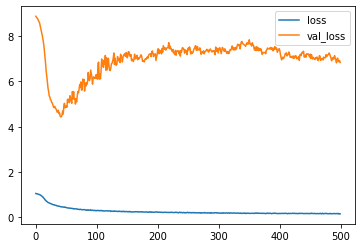

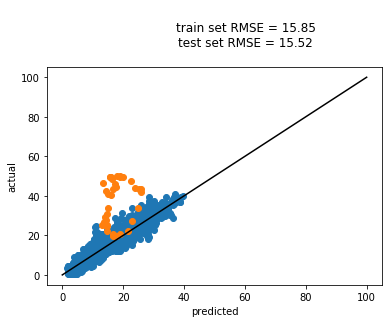

Processing 2134.0
Train on 2684 samples, validate on 35 samples
Epoch 1/500
 - 2s - loss: 1.0404 - mse: 1.0104 - val_loss: 0.3848 - val_mse: 0.3550
Epoch 2/500
 - 0s - loss: 1.0337 - mse: 1.0040 - val_loss: 0.3818 - val_mse: 0.3521
Epoch 3/500
 - 0s - loss: 1.0284 - mse: 0.9988 - val_loss: 0.3784 - val_mse: 0.3490
Epoch 4/500
 - 0s - loss: 1.0229 - mse: 0.9935 - val_loss: 0.3750 - val_mse: 0.3457
Epoch 5/500
 - 0s - loss: 1.0162 - mse: 0.9869 - val_loss: 0.3709 - val_mse: 0.3419
Epoch 6/500
 - 0s - loss: 1.0109 - mse: 0.9818 - val_loss: 0.3661 - val_mse: 0.3372
Epoch 7/500
 - 0s - loss: 1.0025 - mse: 0.9736 - val_loss: 0.3602 - val_mse: 0.3315
Epoch 8/500
 - 0s - loss: 0.9949 - mse: 0.9663 - val_loss: 0.3520 - val_mse: 0.3235
Epoch 9/500
 - 0s - loss: 0.9843 - mse: 0.9558 - val_loss: 0.3434 - val_mse: 0.3150
Epoch 10/500
 - 0s - loss: 0.9718 - mse: 0.9434 - val_loss: 0.3319 - val_mse: 0.3037
Epoch 11/500
 - 0s - loss: 0.9559 - mse: 0.9278 - val_loss: 0.3189 - val_mse: 0.2908
Epoch 12/5

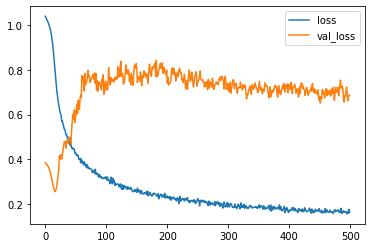

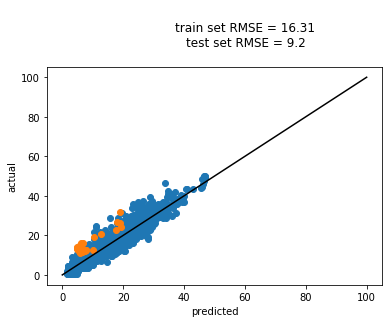

Processing 2142.0
Train on 2690 samples, validate on 29 samples
Epoch 1/500
 - 2s - loss: 1.0366 - mse: 1.0067 - val_loss: 0.3727 - val_mse: 0.3429
Epoch 2/500
 - 0s - loss: 1.0303 - mse: 1.0005 - val_loss: 0.3640 - val_mse: 0.3344
Epoch 3/500
 - 0s - loss: 1.0235 - mse: 0.9939 - val_loss: 0.3552 - val_mse: 0.3257
Epoch 4/500
 - 0s - loss: 1.0159 - mse: 0.9865 - val_loss: 0.3399 - val_mse: 0.3107
Epoch 5/500
 - 0s - loss: 1.0073 - mse: 0.9780 - val_loss: 0.3378 - val_mse: 0.3087
Epoch 6/500
 - 0s - loss: 0.9927 - mse: 0.9636 - val_loss: 0.3300 - val_mse: 0.3011
Epoch 7/500
 - 0s - loss: 0.9772 - mse: 0.9482 - val_loss: 0.3030 - val_mse: 0.2742
Epoch 8/500
 - 0s - loss: 0.9597 - mse: 0.9310 - val_loss: 0.2917 - val_mse: 0.2631
Epoch 9/500
 - 0s - loss: 0.9362 - mse: 0.9075 - val_loss: 0.2727 - val_mse: 0.2442
Epoch 10/500
 - 0s - loss: 0.9112 - mse: 0.8827 - val_loss: 0.2499 - val_mse: 0.2215
Epoch 11/500
 - 0s - loss: 0.8830 - mse: 0.8546 - val_loss: 0.2265 - val_mse: 0.1982
Epoch 12/5

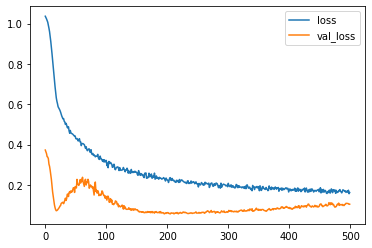

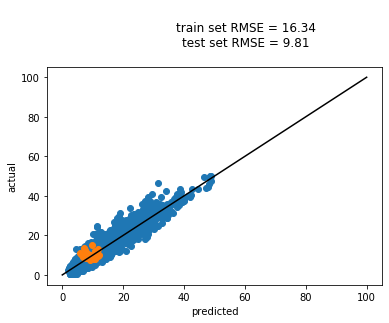

Processing 2138.0
Train on 2679 samples, validate on 40 samples
Epoch 1/500
 - 2s - loss: 1.0210 - mse: 0.9910 - val_loss: 0.0849 - val_mse: 0.0551
Epoch 2/500
 - 0s - loss: 1.0147 - mse: 0.9850 - val_loss: 0.0840 - val_mse: 0.0544
Epoch 3/500
 - 0s - loss: 1.0086 - mse: 0.9790 - val_loss: 0.0835 - val_mse: 0.0541
Epoch 4/500
 - 0s - loss: 1.0007 - mse: 0.9713 - val_loss: 0.0842 - val_mse: 0.0549
Epoch 5/500
 - 0s - loss: 0.9907 - mse: 0.9615 - val_loss: 0.0852 - val_mse: 0.0560
Epoch 6/500
 - 0s - loss: 0.9792 - mse: 0.9501 - val_loss: 0.0898 - val_mse: 0.0608
Epoch 7/500
 - 0s - loss: 0.9633 - mse: 0.9343 - val_loss: 0.0981 - val_mse: 0.0693
Epoch 8/500
 - 0s - loss: 0.9451 - mse: 0.9163 - val_loss: 0.1126 - val_mse: 0.0839
Epoch 9/500
 - 0s - loss: 0.9226 - mse: 0.8939 - val_loss: 0.1400 - val_mse: 0.1114
Epoch 10/500
 - 0s - loss: 0.8963 - mse: 0.8678 - val_loss: 0.1808 - val_mse: 0.1523
Epoch 11/500
 - 0s - loss: 0.8623 - mse: 0.8338 - val_loss: 0.2370 - val_mse: 0.2086
Epoch 12/5

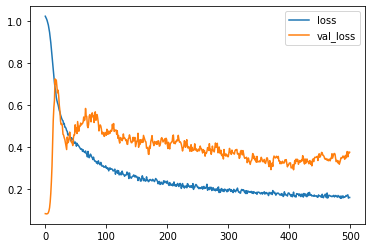

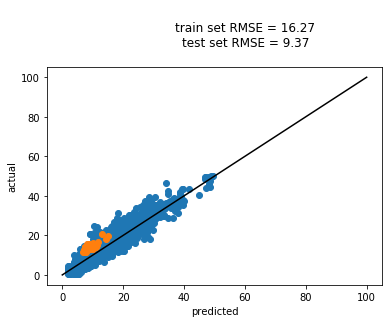

Processing 2145.0
Train on 2675 samples, validate on 44 samples
Epoch 1/500
 - 2s - loss: 1.0397 - mse: 1.0097 - val_loss: 0.4164 - val_mse: 0.3866
Epoch 2/500
 - 0s - loss: 1.0261 - mse: 0.9964 - val_loss: 0.4274 - val_mse: 0.3978
Epoch 3/500
 - 0s - loss: 1.0158 - mse: 0.9862 - val_loss: 0.4346 - val_mse: 0.4052
Epoch 4/500
 - 0s - loss: 1.0036 - mse: 0.9742 - val_loss: 0.4409 - val_mse: 0.4116
Epoch 5/500
 - 0s - loss: 0.9918 - mse: 0.9626 - val_loss: 0.4492 - val_mse: 0.4201
Epoch 6/500
 - 0s - loss: 0.9782 - mse: 0.9491 - val_loss: 0.4524 - val_mse: 0.4234
Epoch 7/500
 - 0s - loss: 0.9614 - mse: 0.9325 - val_loss: 0.4730 - val_mse: 0.4442
Epoch 8/500
 - 0s - loss: 0.9411 - mse: 0.9123 - val_loss: 0.4846 - val_mse: 0.4560
Epoch 9/500
 - 0s - loss: 0.9198 - mse: 0.8911 - val_loss: 0.4965 - val_mse: 0.4680
Epoch 10/500
 - 0s - loss: 0.8892 - mse: 0.8607 - val_loss: 0.5100 - val_mse: 0.4816
Epoch 11/500
 - 0s - loss: 0.8580 - mse: 0.8296 - val_loss: 0.5352 - val_mse: 0.5069
Epoch 12/5

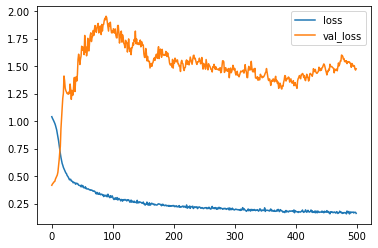

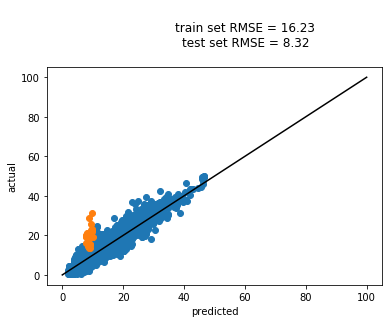

Processing 2218.0
Train on 2687 samples, validate on 32 samples
Epoch 1/500
 - 3s - loss: 1.0346 - mse: 1.0046 - val_loss: 0.4929 - val_mse: 0.4631
Epoch 2/500
 - 0s - loss: 1.0292 - mse: 0.9995 - val_loss: 0.4913 - val_mse: 0.4616
Epoch 3/500
 - 0s - loss: 1.0230 - mse: 0.9934 - val_loss: 0.4885 - val_mse: 0.4590
Epoch 4/500
 - 0s - loss: 1.0164 - mse: 0.9870 - val_loss: 0.4885 - val_mse: 0.4592
Epoch 5/500
 - 0s - loss: 1.0079 - mse: 0.9786 - val_loss: 0.4911 - val_mse: 0.4621
Epoch 6/500
 - 0s - loss: 0.9987 - mse: 0.9697 - val_loss: 0.4900 - val_mse: 0.4611
Epoch 7/500
 - 0s - loss: 0.9858 - mse: 0.9569 - val_loss: 0.4953 - val_mse: 0.4665
Epoch 8/500
 - 0s - loss: 0.9712 - mse: 0.9424 - val_loss: 0.4990 - val_mse: 0.4704
Epoch 9/500
 - 0s - loss: 0.9519 - mse: 0.9233 - val_loss: 0.5007 - val_mse: 0.4722
Epoch 10/500
 - 0s - loss: 0.9315 - mse: 0.9030 - val_loss: 0.5056 - val_mse: 0.4772
Epoch 11/500
 - 0s - loss: 0.9046 - mse: 0.8763 - val_loss: 0.5075 - val_mse: 0.4792
Epoch 12/5

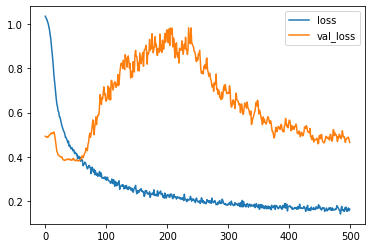

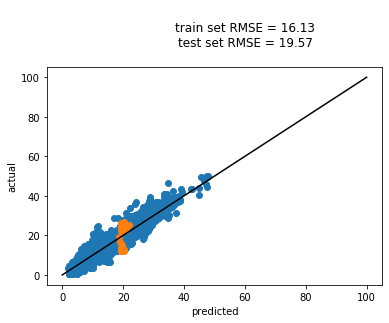

Processing 2137.0
Train on 2682 samples, validate on 37 samples
Epoch 1/500
 - 3s - loss: 1.0311 - mse: 1.0011 - val_loss: 0.4544 - val_mse: 0.4246
Epoch 2/500
 - 0s - loss: 1.0273 - mse: 0.9976 - val_loss: 0.4552 - val_mse: 0.4256
Epoch 3/500
 - 0s - loss: 1.0248 - mse: 0.9952 - val_loss: 0.4474 - val_mse: 0.4180
Epoch 4/500
 - 0s - loss: 1.0210 - mse: 0.9915 - val_loss: 0.4481 - val_mse: 0.4188
Epoch 5/500
 - 0s - loss: 1.0165 - mse: 0.9872 - val_loss: 0.4413 - val_mse: 0.4122
Epoch 6/500
 - 0s - loss: 1.0114 - mse: 0.9824 - val_loss: 0.4347 - val_mse: 0.4058
Epoch 7/500
 - 0s - loss: 1.0045 - mse: 0.9756 - val_loss: 0.4223 - val_mse: 0.3936
Epoch 8/500
 - 0s - loss: 0.9967 - mse: 0.9680 - val_loss: 0.4115 - val_mse: 0.3829
Epoch 9/500
 - 0s - loss: 0.9852 - mse: 0.9567 - val_loss: 0.3977 - val_mse: 0.3693
Epoch 10/500
 - 0s - loss: 0.9708 - mse: 0.9425 - val_loss: 0.3922 - val_mse: 0.3640
Epoch 11/500
 - 0s - loss: 0.9521 - mse: 0.9239 - val_loss: 0.3790 - val_mse: 0.3509
Epoch 12/5

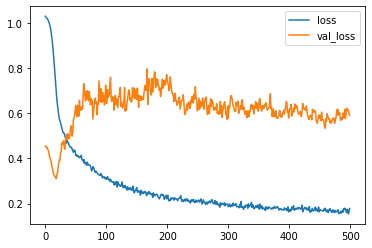

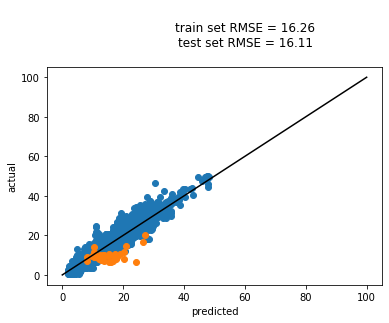

Processing 2128.0
Train on 2665 samples, validate on 54 samples
Epoch 1/500
 - 3s - loss: 1.0317 - mse: 1.0017 - val_loss: 0.1268 - val_mse: 0.0971
Epoch 2/500
 - 0s - loss: 1.0233 - mse: 0.9936 - val_loss: 0.1265 - val_mse: 0.0969
Epoch 3/500
 - 0s - loss: 1.0168 - mse: 0.9872 - val_loss: 0.1248 - val_mse: 0.0953
Epoch 4/500
 - 0s - loss: 1.0089 - mse: 0.9795 - val_loss: 0.1229 - val_mse: 0.0936
Epoch 5/500
 - 0s - loss: 1.0008 - mse: 0.9715 - val_loss: 0.1231 - val_mse: 0.0940
Epoch 6/500
 - 0s - loss: 0.9910 - mse: 0.9620 - val_loss: 0.1218 - val_mse: 0.0928
Epoch 7/500
 - 0s - loss: 0.9776 - mse: 0.9487 - val_loss: 0.1185 - val_mse: 0.0897
Epoch 8/500
 - 0s - loss: 0.9640 - mse: 0.9352 - val_loss: 0.1184 - val_mse: 0.0898
Epoch 9/500
 - 0s - loss: 0.9451 - mse: 0.9165 - val_loss: 0.1129 - val_mse: 0.0844
Epoch 10/500
 - 0s - loss: 0.9260 - mse: 0.8975 - val_loss: 0.1078 - val_mse: 0.0794
Epoch 11/500
 - 0s - loss: 0.9014 - mse: 0.8730 - val_loss: 0.1020 - val_mse: 0.0737
Epoch 12/5

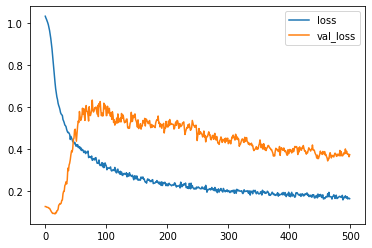

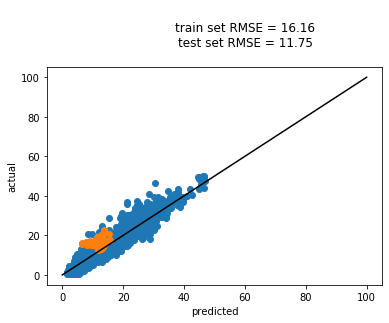

Processing 2139.0
Train on 2688 samples, validate on 31 samples
Epoch 1/500
 - 3s - loss: 1.0476 - mse: 1.0176 - val_loss: 0.2849 - val_mse: 0.2551
Epoch 2/500
 - 0s - loss: 1.0396 - mse: 1.0098 - val_loss: 0.2855 - val_mse: 0.2559
Epoch 3/500
 - 0s - loss: 1.0343 - mse: 1.0047 - val_loss: 0.2896 - val_mse: 0.2601
Epoch 4/500
 - 0s - loss: 1.0282 - mse: 0.9988 - val_loss: 0.2990 - val_mse: 0.2697
Epoch 5/500
 - 0s - loss: 1.0226 - mse: 0.9934 - val_loss: 0.3086 - val_mse: 0.2795
Epoch 6/500
 - 0s - loss: 1.0148 - mse: 0.9857 - val_loss: 0.3104 - val_mse: 0.2815
Epoch 7/500
 - 0s - loss: 1.0069 - mse: 0.9780 - val_loss: 0.3130 - val_mse: 0.2842
Epoch 8/500
 - 0s - loss: 0.9959 - mse: 0.9672 - val_loss: 0.3235 - val_mse: 0.2949
Epoch 9/500
 - 0s - loss: 0.9847 - mse: 0.9562 - val_loss: 0.3373 - val_mse: 0.3089
Epoch 10/500
 - 0s - loss: 0.9679 - mse: 0.9395 - val_loss: 0.3618 - val_mse: 0.3336
Epoch 11/500
 - 0s - loss: 0.9505 - mse: 0.9223 - val_loss: 0.3808 - val_mse: 0.3527
Epoch 12/5

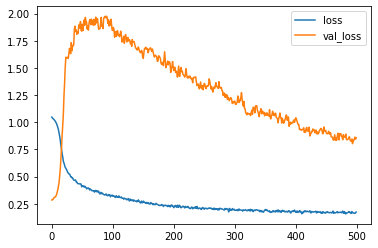

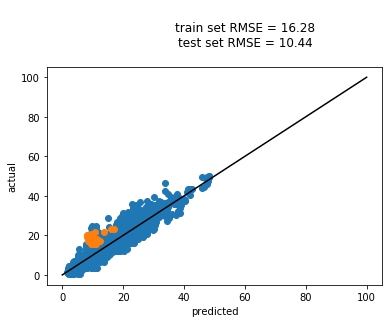

Processing 2121.0
Train on 2667 samples, validate on 52 samples
Epoch 1/500
 - 3s - loss: 1.0247 - mse: 0.9947 - val_loss: 0.8907 - val_mse: 0.8610
Epoch 2/500
 - 0s - loss: 1.0198 - mse: 0.9901 - val_loss: 0.8852 - val_mse: 0.8556
Epoch 3/500
 - 0s - loss: 1.0160 - mse: 0.9864 - val_loss: 0.8695 - val_mse: 0.8401
Epoch 4/500
 - 0s - loss: 1.0109 - mse: 0.9815 - val_loss: 0.8634 - val_mse: 0.8342
Epoch 5/500
 - 0s - loss: 1.0053 - mse: 0.9761 - val_loss: 0.8425 - val_mse: 0.8135
Epoch 6/500
 - 0s - loss: 0.9982 - mse: 0.9691 - val_loss: 0.8203 - val_mse: 0.7914
Epoch 7/500
 - 0s - loss: 0.9898 - mse: 0.9610 - val_loss: 0.7935 - val_mse: 0.7648
Epoch 8/500
 - 0s - loss: 0.9794 - mse: 0.9507 - val_loss: 0.7725 - val_mse: 0.7439
Epoch 9/500
 - 0s - loss: 0.9649 - mse: 0.9364 - val_loss: 0.7345 - val_mse: 0.7061
Epoch 10/500
 - 0s - loss: 0.9499 - mse: 0.9216 - val_loss: 0.6908 - val_mse: 0.6625
Epoch 11/500
 - 0s - loss: 0.9305 - mse: 0.9023 - val_loss: 0.6478 - val_mse: 0.6196
Epoch 12/5

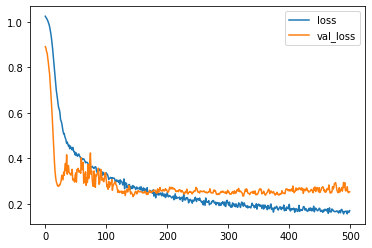

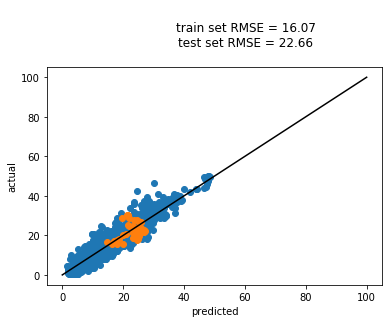

Processing 2015.0
Train on 2678 samples, validate on 41 samples
Epoch 1/500
 - 3s - loss: 1.0290 - mse: 0.9990 - val_loss: 0.1261 - val_mse: 0.0963
Epoch 2/500
 - 0s - loss: 1.0244 - mse: 0.9946 - val_loss: 0.1240 - val_mse: 0.0944
Epoch 3/500
 - 0s - loss: 1.0203 - mse: 0.9907 - val_loss: 0.1240 - val_mse: 0.0946
Epoch 4/500
 - 0s - loss: 1.0149 - mse: 0.9855 - val_loss: 0.1175 - val_mse: 0.0882
Epoch 5/500
 - 0s - loss: 1.0074 - mse: 0.9782 - val_loss: 0.1162 - val_mse: 0.0872
Epoch 6/500
 - 0s - loss: 0.9986 - mse: 0.9695 - val_loss: 0.1134 - val_mse: 0.0845
Epoch 7/500
 - 0s - loss: 0.9880 - mse: 0.9591 - val_loss: 0.1041 - val_mse: 0.0754
Epoch 8/500
 - 0s - loss: 0.9735 - mse: 0.9448 - val_loss: 0.0965 - val_mse: 0.0679
Epoch 9/500
 - 0s - loss: 0.9559 - mse: 0.9274 - val_loss: 0.0875 - val_mse: 0.0590
Epoch 10/500
 - 0s - loss: 0.9344 - mse: 0.9060 - val_loss: 0.0778 - val_mse: 0.0495
Epoch 11/500
 - 0s - loss: 0.9102 - mse: 0.8819 - val_loss: 0.0670 - val_mse: 0.0387
Epoch 12/5

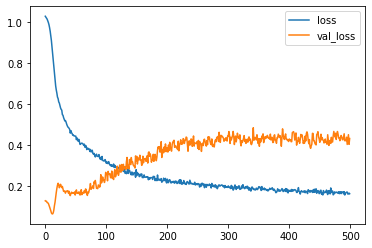

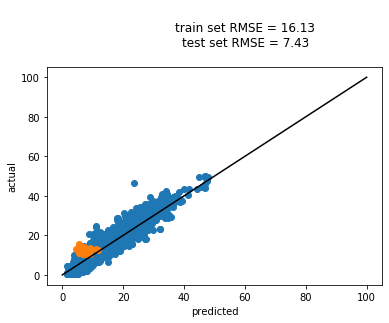

Processing 2116.0
Train on 2704 samples, validate on 15 samples
Epoch 1/500
 - 3s - loss: 1.0141 - mse: 0.9841 - val_loss: 8.1376 - val_mse: 8.1078
Epoch 2/500
 - 0s - loss: 1.0063 - mse: 0.9766 - val_loss: 8.2039 - val_mse: 8.1743
Epoch 3/500
 - 0s - loss: 0.9994 - mse: 0.9698 - val_loss: 8.2896 - val_mse: 8.2602
Epoch 4/500
 - 0s - loss: 0.9916 - mse: 0.9621 - val_loss: 8.3819 - val_mse: 8.3526
Epoch 5/500
 - 0s - loss: 0.9838 - mse: 0.9546 - val_loss: 8.4582 - val_mse: 8.4291
Epoch 6/500
 - 0s - loss: 0.9716 - mse: 0.9425 - val_loss: 8.5346 - val_mse: 8.5056
Epoch 7/500
 - 0s - loss: 0.9582 - mse: 0.9292 - val_loss: 8.6367 - val_mse: 8.6079
Epoch 8/500
 - 0s - loss: 0.9445 - mse: 0.9157 - val_loss: 8.8084 - val_mse: 8.7797
Epoch 9/500
 - 0s - loss: 0.9252 - mse: 0.8965 - val_loss: 9.0182 - val_mse: 8.9896
Epoch 10/500
 - 0s - loss: 0.9035 - mse: 0.8750 - val_loss: 9.2274 - val_mse: 9.1988
Epoch 11/500
 - 0s - loss: 0.8809 - mse: 0.8524 - val_loss: 9.5568 - val_mse: 9.5284
Epoch 12/5

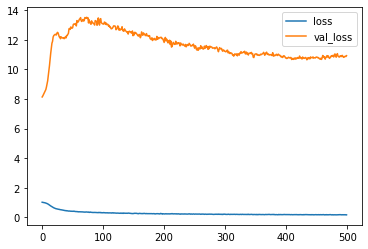

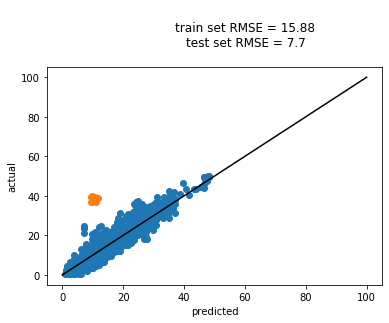

Processing 2069.0
Train on 2691 samples, validate on 28 samples
Epoch 1/500
 - 3s - loss: 1.0263 - mse: 0.9963 - val_loss: 2.8778 - val_mse: 2.8480
Epoch 2/500
 - 0s - loss: 1.0186 - mse: 0.9889 - val_loss: 2.8764 - val_mse: 2.8468
Epoch 3/500
 - 0s - loss: 1.0113 - mse: 0.9817 - val_loss: 2.8902 - val_mse: 2.8608
Epoch 4/500
 - 0s - loss: 1.0055 - mse: 0.9760 - val_loss: 2.8861 - val_mse: 2.8568
Epoch 5/500
 - 0s - loss: 0.9960 - mse: 0.9668 - val_loss: 2.8731 - val_mse: 2.8440
Epoch 6/500
 - 0s - loss: 0.9857 - mse: 0.9566 - val_loss: 2.8798 - val_mse: 2.8509
Epoch 7/500
 - 0s - loss: 0.9727 - mse: 0.9438 - val_loss: 2.8732 - val_mse: 2.8444
Epoch 8/500
 - 0s - loss: 0.9579 - mse: 0.9291 - val_loss: 2.8774 - val_mse: 2.8488
Epoch 9/500
 - 0s - loss: 0.9400 - mse: 0.9114 - val_loss: 2.8993 - val_mse: 2.8708
Epoch 10/500
 - 0s - loss: 0.9189 - mse: 0.8904 - val_loss: 2.9176 - val_mse: 2.8892
Epoch 11/500
 - 0s - loss: 0.8992 - mse: 0.8709 - val_loss: 2.9261 - val_mse: 2.8978
Epoch 12/5

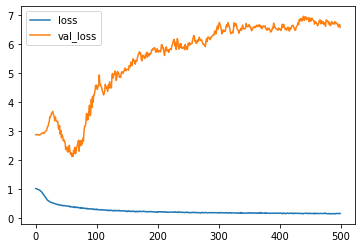

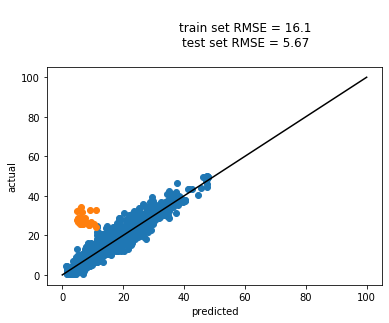

Processing 2006.0
Train on 2691 samples, validate on 28 samples
Epoch 1/500
 - 4s - loss: 1.0334 - mse: 1.0034 - val_loss: 2.7556 - val_mse: 2.7258
Epoch 2/500
 - 0s - loss: 1.0282 - mse: 0.9984 - val_loss: 2.7680 - val_mse: 2.7384
Epoch 3/500
 - 0s - loss: 1.0238 - mse: 0.9942 - val_loss: 2.7731 - val_mse: 2.7436
Epoch 4/500
 - 0s - loss: 1.0190 - mse: 0.9896 - val_loss: 2.7732 - val_mse: 2.7439
Epoch 5/500
 - 0s - loss: 1.0126 - mse: 0.9834 - val_loss: 2.7836 - val_mse: 2.7545
Epoch 6/500
 - 0s - loss: 1.0044 - mse: 0.9754 - val_loss: 2.7863 - val_mse: 2.7574
Epoch 7/500
 - 0s - loss: 0.9929 - mse: 0.9640 - val_loss: 2.8181 - val_mse: 2.7893
Epoch 8/500
 - 0s - loss: 0.9803 - mse: 0.9516 - val_loss: 2.7993 - val_mse: 2.7708
Epoch 9/500
 - 0s - loss: 0.9655 - mse: 0.9370 - val_loss: 2.8032 - val_mse: 2.7748
Epoch 10/500
 - 0s - loss: 0.9449 - mse: 0.9165 - val_loss: 2.8022 - val_mse: 2.7740
Epoch 11/500
 - 0s - loss: 0.9244 - mse: 0.8961 - val_loss: 2.7941 - val_mse: 2.7659
Epoch 12/5

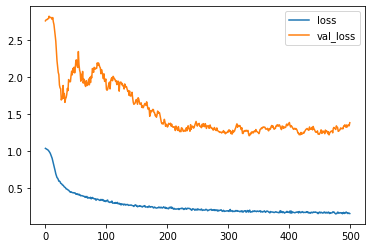

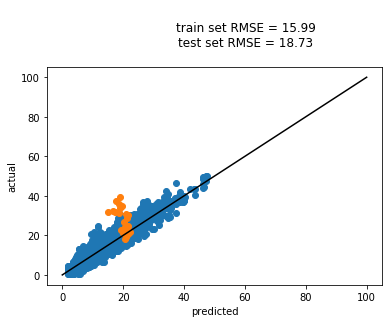

Processing 2168.0
Train on 2709 samples, validate on 10 samples
Epoch 1/500
 - 3s - loss: 1.0257 - mse: 0.9958 - val_loss: 1.5549 - val_mse: 1.5251
Epoch 2/500
 - 0s - loss: 1.0210 - mse: 0.9912 - val_loss: 1.5497 - val_mse: 1.5201
Epoch 3/500
 - 0s - loss: 1.0154 - mse: 0.9858 - val_loss: 1.5613 - val_mse: 1.5319
Epoch 4/500
 - 0s - loss: 1.0094 - mse: 0.9799 - val_loss: 1.5686 - val_mse: 1.5393
Epoch 5/500
 - 0s - loss: 1.0025 - mse: 0.9733 - val_loss: 1.5676 - val_mse: 1.5385
Epoch 6/500
 - 0s - loss: 0.9936 - mse: 0.9646 - val_loss: 1.5971 - val_mse: 1.5682
Epoch 7/500
 - 0s - loss: 0.9826 - mse: 0.9537 - val_loss: 1.5948 - val_mse: 1.5661
Epoch 8/500
 - 0s - loss: 0.9680 - mse: 0.9392 - val_loss: 1.5958 - val_mse: 1.5672
Epoch 9/500
 - 0s - loss: 0.9517 - mse: 0.9231 - val_loss: 1.6274 - val_mse: 1.5990
Epoch 10/500
 - 0s - loss: 0.9335 - mse: 0.9050 - val_loss: 1.6597 - val_mse: 1.6313
Epoch 11/500
 - 0s - loss: 0.9058 - mse: 0.8775 - val_loss: 1.6832 - val_mse: 1.6549
Epoch 12/5

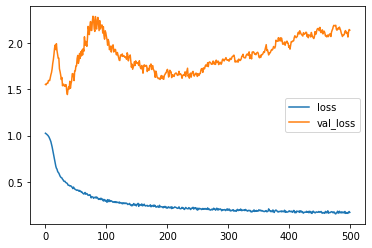

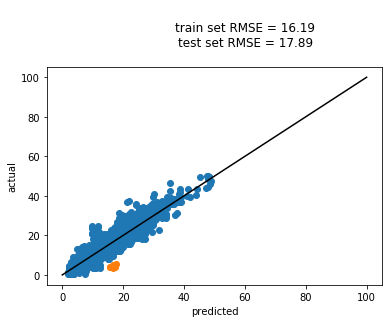

Processing 2021.0
Train on 2681 samples, validate on 38 samples
Epoch 1/500
 - 3s - loss: 1.0375 - mse: 1.0076 - val_loss: 0.3889 - val_mse: 0.3591
Epoch 2/500
 - 0s - loss: 1.0313 - mse: 1.0015 - val_loss: 0.3903 - val_mse: 0.3607
Epoch 3/500
 - 0s - loss: 1.0270 - mse: 0.9974 - val_loss: 0.3916 - val_mse: 0.3622
Epoch 4/500
 - 0s - loss: 1.0217 - mse: 0.9923 - val_loss: 0.3979 - val_mse: 0.3687
Epoch 5/500
 - 0s - loss: 1.0152 - mse: 0.9860 - val_loss: 0.4044 - val_mse: 0.3753
Epoch 6/500
 - 0s - loss: 1.0089 - mse: 0.9798 - val_loss: 0.4134 - val_mse: 0.3845
Epoch 7/500
 - 0s - loss: 1.0009 - mse: 0.9721 - val_loss: 0.4233 - val_mse: 0.3946
Epoch 8/500
 - 0s - loss: 0.9913 - mse: 0.9626 - val_loss: 0.4338 - val_mse: 0.4053
Epoch 9/500
 - 0s - loss: 0.9800 - mse: 0.9515 - val_loss: 0.4426 - val_mse: 0.4142
Epoch 10/500
 - 0s - loss: 0.9658 - mse: 0.9374 - val_loss: 0.4493 - val_mse: 0.4211
Epoch 11/500
 - 0s - loss: 0.9509 - mse: 0.9227 - val_loss: 0.4677 - val_mse: 0.4396
Epoch 12/5

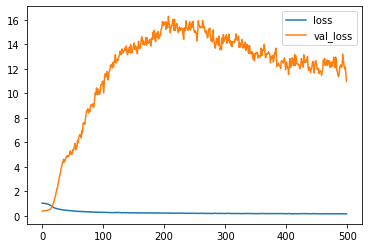

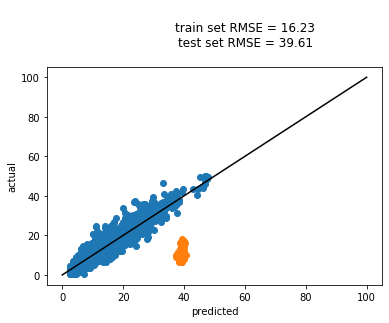

Processing 2118.0
Train on 2671 samples, validate on 48 samples
Epoch 1/500
 - 4s - loss: 1.0187 - mse: 0.9887 - val_loss: 0.3031 - val_mse: 0.2733
Epoch 2/500
 - 0s - loss: 1.0117 - mse: 0.9819 - val_loss: 0.3044 - val_mse: 0.2748
Epoch 3/500
 - 0s - loss: 1.0057 - mse: 0.9761 - val_loss: 0.3080 - val_mse: 0.2785
Epoch 4/500
 - 0s - loss: 0.9974 - mse: 0.9680 - val_loss: 0.3114 - val_mse: 0.2821
Epoch 5/500
 - 0s - loss: 0.9882 - mse: 0.9590 - val_loss: 0.3156 - val_mse: 0.2865
Epoch 6/500
 - 0s - loss: 0.9765 - mse: 0.9475 - val_loss: 0.3192 - val_mse: 0.2902
Epoch 7/500
 - 0s - loss: 0.9659 - mse: 0.9370 - val_loss: 0.3295 - val_mse: 0.3007
Epoch 8/500
 - 0s - loss: 0.9482 - mse: 0.9194 - val_loss: 0.3417 - val_mse: 0.3131
Epoch 9/500
 - 0s - loss: 0.9299 - mse: 0.9013 - val_loss: 0.3532 - val_mse: 0.3247
Epoch 10/500
 - 0s - loss: 0.9099 - mse: 0.8814 - val_loss: 0.3674 - val_mse: 0.3390
Epoch 11/500
 - 0s - loss: 0.8851 - mse: 0.8567 - val_loss: 0.3893 - val_mse: 0.3610
Epoch 12/5

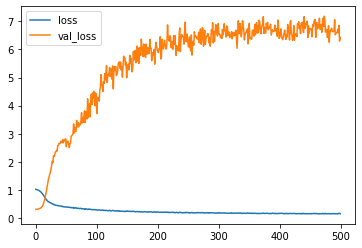

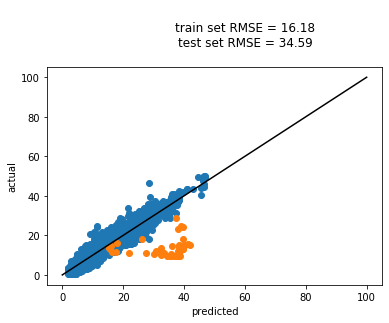

Processing 2133.0
Train on 2678 samples, validate on 41 samples
Epoch 1/500
 - 4s - loss: 1.0327 - mse: 1.0027 - val_loss: 1.0807 - val_mse: 1.0509
Epoch 2/500
 - 0s - loss: 1.0282 - mse: 0.9984 - val_loss: 1.0672 - val_mse: 1.0376
Epoch 3/500
 - 0s - loss: 1.0241 - mse: 0.9945 - val_loss: 1.0572 - val_mse: 1.0278
Epoch 4/500
 - 0s - loss: 1.0190 - mse: 0.9895 - val_loss: 1.0534 - val_mse: 1.0241
Epoch 5/500
 - 0s - loss: 1.0125 - mse: 0.9832 - val_loss: 1.0343 - val_mse: 1.0052
Epoch 6/500
 - 0s - loss: 1.0044 - mse: 0.9753 - val_loss: 1.0110 - val_mse: 0.9821
Epoch 7/500
 - 0s - loss: 0.9940 - mse: 0.9652 - val_loss: 0.9851 - val_mse: 0.9564
Epoch 8/500
 - 0s - loss: 0.9826 - mse: 0.9539 - val_loss: 0.9621 - val_mse: 0.9336
Epoch 9/500
 - 0s - loss: 0.9659 - mse: 0.9374 - val_loss: 0.9100 - val_mse: 0.8816
Epoch 10/500
 - 0s - loss: 0.9440 - mse: 0.9156 - val_loss: 0.8583 - val_mse: 0.8300
Epoch 11/500
 - 0s - loss: 0.9203 - mse: 0.8920 - val_loss: 0.7895 - val_mse: 0.7614
Epoch 12/5

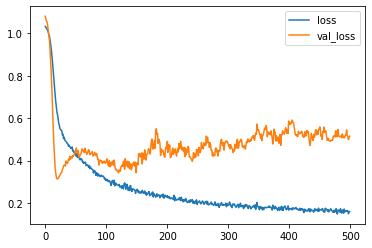

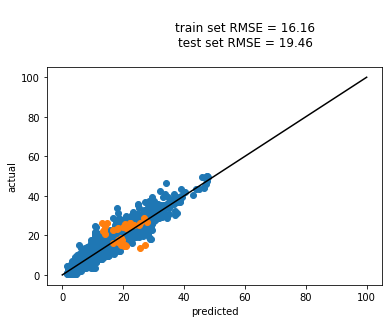

Processing 2170.0
Train on 2667 samples, validate on 52 samples
Epoch 1/500
 - 4s - loss: 1.0423 - mse: 1.0124 - val_loss: 0.6736 - val_mse: 0.6438
Epoch 2/500
 - 0s - loss: 1.0331 - mse: 1.0033 - val_loss: 0.6718 - val_mse: 0.6422
Epoch 3/500
 - 0s - loss: 1.0261 - mse: 0.9965 - val_loss: 0.6791 - val_mse: 0.6496
Epoch 4/500
 - 0s - loss: 1.0185 - mse: 0.9891 - val_loss: 0.6819 - val_mse: 0.6526
Epoch 5/500
 - 0s - loss: 1.0092 - mse: 0.9800 - val_loss: 0.6999 - val_mse: 0.6708
Epoch 6/500
 - 0s - loss: 0.9994 - mse: 0.9703 - val_loss: 0.7145 - val_mse: 0.6856
Epoch 7/500
 - 0s - loss: 0.9890 - mse: 0.9601 - val_loss: 0.7291 - val_mse: 0.7004
Epoch 8/500
 - 0s - loss: 0.9735 - mse: 0.9448 - val_loss: 0.7455 - val_mse: 0.7169
Epoch 9/500
 - 0s - loss: 0.9543 - mse: 0.9258 - val_loss: 0.7644 - val_mse: 0.7360
Epoch 10/500
 - 0s - loss: 0.9321 - mse: 0.9037 - val_loss: 0.7743 - val_mse: 0.7460
Epoch 11/500
 - 0s - loss: 0.9066 - mse: 0.8784 - val_loss: 0.8149 - val_mse: 0.7867
Epoch 12/5

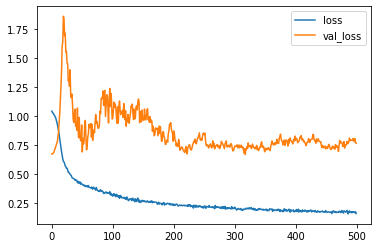

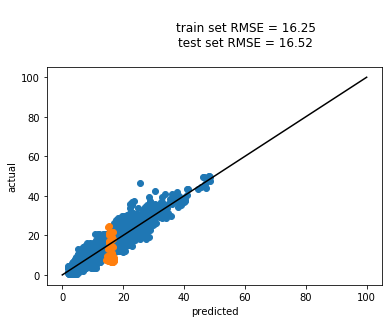

Processing 2184.0
Train on 2664 samples, validate on 55 samples
Epoch 1/500
 - 4s - loss: 1.0402 - mse: 1.0102 - val_loss: 0.1818 - val_mse: 0.1521
Epoch 2/500
 - 0s - loss: 1.0339 - mse: 1.0042 - val_loss: 0.1864 - val_mse: 0.1567
Epoch 3/500
 - 0s - loss: 1.0293 - mse: 0.9997 - val_loss: 0.1880 - val_mse: 0.1586
Epoch 4/500
 - 0s - loss: 1.0240 - mse: 0.9946 - val_loss: 0.1820 - val_mse: 0.1527
Epoch 5/500
 - 0s - loss: 1.0178 - mse: 0.9886 - val_loss: 0.1805 - val_mse: 0.1514
Epoch 6/500
 - 0s - loss: 1.0106 - mse: 0.9816 - val_loss: 0.1816 - val_mse: 0.1527
Epoch 7/500
 - 0s - loss: 1.0011 - mse: 0.9722 - val_loss: 0.1778 - val_mse: 0.1491
Epoch 8/500
 - 0s - loss: 0.9903 - mse: 0.9616 - val_loss: 0.1778 - val_mse: 0.1493
Epoch 9/500
 - 0s - loss: 0.9735 - mse: 0.9449 - val_loss: 0.1790 - val_mse: 0.1506
Epoch 10/500
 - 0s - loss: 0.9560 - mse: 0.9277 - val_loss: 0.1715 - val_mse: 0.1433
Epoch 11/500
 - 0s - loss: 0.9316 - mse: 0.9034 - val_loss: 0.1690 - val_mse: 0.1409
Epoch 12/5

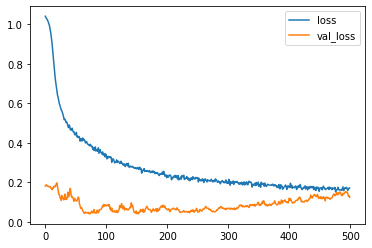

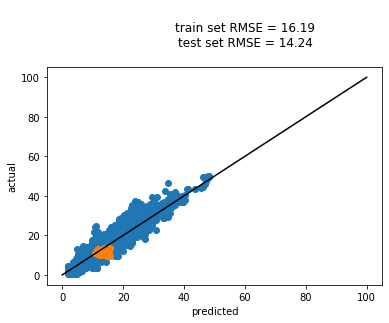

Processing 2156.0
Train on 2686 samples, validate on 33 samples
Epoch 1/500
 - 4s - loss: 1.0447 - mse: 1.0148 - val_loss: 0.2438 - val_mse: 0.2140
Epoch 2/500
 - 0s - loss: 1.0363 - mse: 1.0066 - val_loss: 0.2426 - val_mse: 0.2130
Epoch 3/500
 - 0s - loss: 1.0295 - mse: 0.9999 - val_loss: 0.2411 - val_mse: 0.2116
Epoch 4/500
 - 0s - loss: 1.0236 - mse: 0.9942 - val_loss: 0.2436 - val_mse: 0.2143
Epoch 5/500
 - 0s - loss: 1.0148 - mse: 0.9856 - val_loss: 0.2407 - val_mse: 0.2117
Epoch 6/500
 - 0s - loss: 1.0073 - mse: 0.9782 - val_loss: 0.2383 - val_mse: 0.2094
Epoch 7/500
 - 0s - loss: 0.9972 - mse: 0.9683 - val_loss: 0.2397 - val_mse: 0.2109
Epoch 8/500
 - 0s - loss: 0.9846 - mse: 0.9559 - val_loss: 0.2445 - val_mse: 0.2160
Epoch 9/500
 - 0s - loss: 0.9715 - mse: 0.9430 - val_loss: 0.2374 - val_mse: 0.2090
Epoch 10/500
 - 0s - loss: 0.9541 - mse: 0.9257 - val_loss: 0.2348 - val_mse: 0.2065
Epoch 11/500
 - 0s - loss: 0.9362 - mse: 0.9080 - val_loss: 0.2380 - val_mse: 0.2098
Epoch 12/5

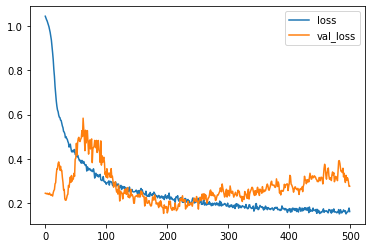

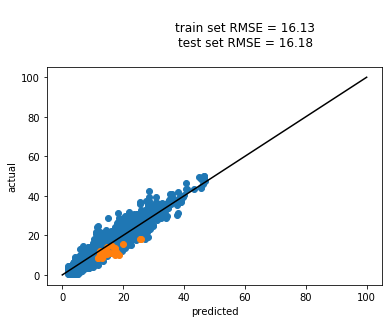

Processing 2183.0
Train on 2682 samples, validate on 37 samples
Epoch 1/500
 - 4s - loss: 1.0172 - mse: 0.9872 - val_loss: 1.0578 - val_mse: 1.0280
Epoch 2/500
 - 0s - loss: 1.0064 - mse: 0.9767 - val_loss: 1.0380 - val_mse: 1.0083
Epoch 3/500
 - 0s - loss: 0.9973 - mse: 0.9677 - val_loss: 1.0059 - val_mse: 0.9765
Epoch 4/500
 - 0s - loss: 0.9892 - mse: 0.9597 - val_loss: 0.9680 - val_mse: 0.9387
Epoch 5/500
 - 0s - loss: 0.9741 - mse: 0.9449 - val_loss: 0.9490 - val_mse: 0.9199
Epoch 6/500
 - 0s - loss: 0.9571 - mse: 0.9280 - val_loss: 0.8982 - val_mse: 0.8693
Epoch 7/500
 - 0s - loss: 0.9419 - mse: 0.9130 - val_loss: 0.8626 - val_mse: 0.8338
Epoch 8/500
 - 0s - loss: 0.9218 - mse: 0.8930 - val_loss: 0.8184 - val_mse: 0.7897
Epoch 9/500
 - 0s - loss: 0.8990 - mse: 0.8703 - val_loss: 0.7846 - val_mse: 0.7560
Epoch 10/500
 - 0s - loss: 0.8719 - mse: 0.8433 - val_loss: 0.7305 - val_mse: 0.7019
Epoch 11/500
 - 0s - loss: 0.8400 - mse: 0.8115 - val_loss: 0.6881 - val_mse: 0.6596
Epoch 12/5

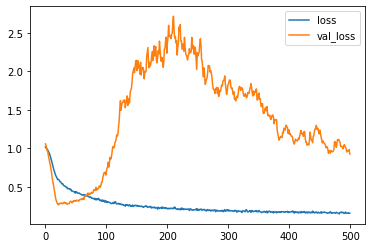

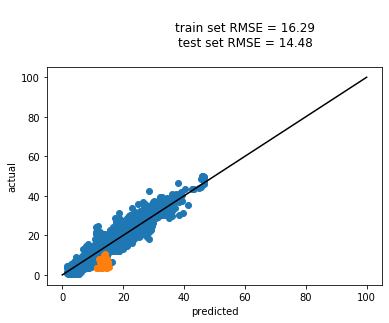

Processing 2155.0
Train on 2680 samples, validate on 39 samples
Epoch 1/500
 - 4s - loss: 1.0380 - mse: 1.0080 - val_loss: 1.1136 - val_mse: 1.0838
Epoch 2/500
 - 0s - loss: 1.0338 - mse: 1.0040 - val_loss: 1.1178 - val_mse: 1.0882
Epoch 3/500
 - 0s - loss: 1.0308 - mse: 1.0012 - val_loss: 1.1112 - val_mse: 1.0817
Epoch 4/500
 - 0s - loss: 1.0267 - mse: 0.9973 - val_loss: 1.1150 - val_mse: 1.0857
Epoch 5/500
 - 0s - loss: 1.0224 - mse: 0.9931 - val_loss: 1.1038 - val_mse: 1.0747
Epoch 6/500
 - 0s - loss: 1.0156 - mse: 0.9865 - val_loss: 1.0982 - val_mse: 1.0694
Epoch 7/500
 - 0s - loss: 1.0081 - mse: 0.9792 - val_loss: 1.0804 - val_mse: 1.0517
Epoch 8/500
 - 0s - loss: 0.9983 - mse: 0.9696 - val_loss: 1.0618 - val_mse: 1.0333
Epoch 9/500
 - 0s - loss: 0.9847 - mse: 0.9562 - val_loss: 1.0462 - val_mse: 1.0179
Epoch 10/500
 - 0s - loss: 0.9699 - mse: 0.9415 - val_loss: 1.0288 - val_mse: 1.0006
Epoch 11/500
 - 0s - loss: 0.9511 - mse: 0.9229 - val_loss: 0.9971 - val_mse: 0.9690
Epoch 12/5

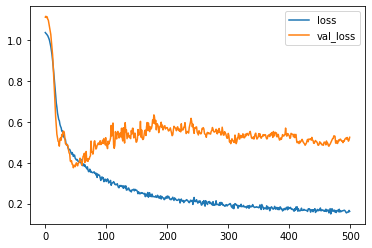

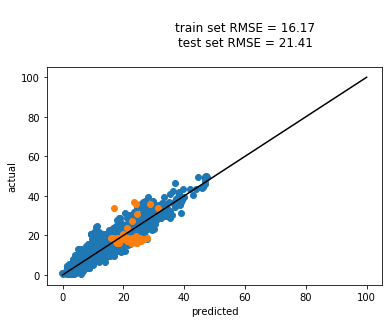

Processing 2162.0
Train on 2678 samples, validate on 41 samples
Epoch 1/500
 - 5s - loss: 1.0408 - mse: 1.0108 - val_loss: 1.0178 - val_mse: 0.9880
Epoch 2/500
 - 0s - loss: 1.0342 - mse: 1.0045 - val_loss: 1.0096 - val_mse: 0.9800
Epoch 3/500
 - 0s - loss: 1.0290 - mse: 0.9994 - val_loss: 0.9948 - val_mse: 0.9654
Epoch 4/500
 - 0s - loss: 1.0241 - mse: 0.9947 - val_loss: 0.9792 - val_mse: 0.9500
Epoch 5/500
 - 0s - loss: 1.0191 - mse: 0.9898 - val_loss: 0.9798 - val_mse: 0.9507
Epoch 6/500
 - 0s - loss: 1.0127 - mse: 0.9837 - val_loss: 0.9774 - val_mse: 0.9485
Epoch 7/500
 - 0s - loss: 1.0047 - mse: 0.9758 - val_loss: 0.9680 - val_mse: 0.9393
Epoch 8/500
 - 0s - loss: 0.9960 - mse: 0.9673 - val_loss: 0.9506 - val_mse: 0.9221
Epoch 9/500
 - 0s - loss: 0.9840 - mse: 0.9555 - val_loss: 0.9323 - val_mse: 0.9040
Epoch 10/500
 - 0s - loss: 0.9688 - mse: 0.9405 - val_loss: 0.9183 - val_mse: 0.8901
Epoch 11/500
 - 0s - loss: 0.9518 - mse: 0.9236 - val_loss: 0.8977 - val_mse: 0.8696
Epoch 12/5

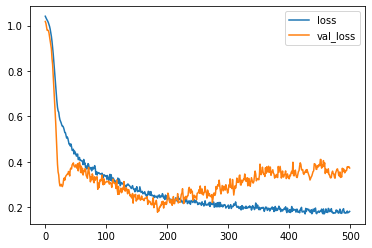

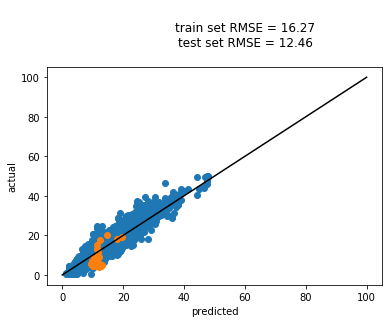

Processing 2117.0
Train on 2671 samples, validate on 48 samples
Epoch 1/500
 - 5s - loss: 1.0395 - mse: 1.0095 - val_loss: 3.6159 - val_mse: 3.5861
Epoch 2/500
 - 0s - loss: 1.0353 - mse: 1.0055 - val_loss: 3.5863 - val_mse: 3.5567
Epoch 3/500
 - 0s - loss: 1.0318 - mse: 1.0022 - val_loss: 3.5675 - val_mse: 3.5380
Epoch 4/500
 - 0s - loss: 1.0283 - mse: 0.9989 - val_loss: 3.5606 - val_mse: 3.5313
Epoch 5/500
 - 0s - loss: 1.0243 - mse: 0.9951 - val_loss: 3.5254 - val_mse: 3.4963
Epoch 6/500
 - 0s - loss: 1.0206 - mse: 0.9915 - val_loss: 3.4928 - val_mse: 3.4639
Epoch 7/500
 - 0s - loss: 1.0168 - mse: 0.9880 - val_loss: 3.4865 - val_mse: 3.4578
Epoch 8/500
 - 0s - loss: 1.0102 - mse: 0.9816 - val_loss: 3.4359 - val_mse: 3.4074
Epoch 9/500
 - 0s - loss: 1.0029 - mse: 0.9745 - val_loss: 3.3809 - val_mse: 3.3526
Epoch 10/500
 - 0s - loss: 0.9947 - mse: 0.9664 - val_loss: 3.3381 - val_mse: 3.3099
Epoch 11/500
 - 0s - loss: 0.9838 - mse: 0.9557 - val_loss: 3.2616 - val_mse: 3.2336
Epoch 12/5

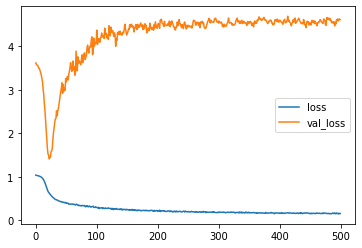

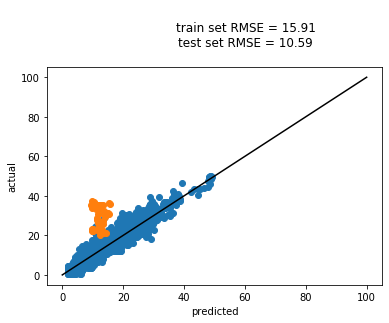

Processing 2166.0
Train on 2668 samples, validate on 51 samples


KeyboardInterrupt: 

In [44]:
for i in random.sample(set(df.site.unique()), len(df.site.unique())):

    print("Processing {}".format(i))
    
    # Hold one out cross validation - loop through sites and select 1 to test on and the rest to train 
    sdf = df[df.site == i]
    y_test = sdf.ws
    X_test = sdf.drop(["site","ws"], axis=1)

    nsdf = df[df.site != i]
    y_train = nsdf.ws 
    X_train = nsdf.drop(["site","ws"], axis=1)
        
    # Scale data
    transformer_x = StandardScaler().fit(X_train)
    transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
#     transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
#     transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 3
    n_features = 19

    X_train = X_train.reshape((X_train.shape[0], n_lags, 24))
    X_test = X_test.reshape((X_test.shape[0], n_lags, 24))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    model = build_model(input_shape=input_shape)
    
    # Fit
#     model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=1)
    
    train_history = model.fit(X_train, y_train,epochs = 500,
                    batch_size=2000,
                    verbose=2, validation_data=(X_test, y_test))
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_acc = train_history.history['val_mse']

    # Get the predictions
    yhat_train = model.predict(X_train)
    
    trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
    trainY = transformer_y.inverse_transform(y_train)
    
    yhat = model.predict(X_test)
    testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
    testY = transformer_y.inverse_transform(y_test)

    trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    
    out["test_preds"] = testPredict
    out["train_preds"] = trainPredict
    
    out["test_act"] = testY
    out["train_act"] = trainY
    
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()

    plt.scatter(trainPredict, trainY)
    plt.scatter(testPredict, testY)
    plt.plot([0, 100], [0, 100], 'k-')
    plt.title('''
                train set RMSE = {}
                test set RMSE = {}
                '''.format(round(trainScore,2),round(testScore,2)))

    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

In [ ]:
len(df.dropna())

In [ ]:
df.columns

In [ ]:
df = analysis_df.copy()
df.replace([np.inf, -np.inf], np.nan, inplace = True)
t = df.groupby(['site']).resample('12D').mean().fillna(np.nan).dropna()
t = t.reset_index(level=0, drop=True)

In [ ]:
# Drop nonconsecutive rows 

filtered = []

for i in t.site.unique():
    sdf = t[t.site==i]
    
    for i in sdf.index:
        begin = i
        end = begin + pd.Timedelta(days=12)
        temp = sdf[begin:end]
        num_points = len(temp)
        if num_points<1:
            print(t)
        else:
            filtered.append(temp)

filt = pd.concat(filtered).dropna()
filt = filt.drop_duplicates() 

In [ ]:
df = filt.copy()

In [ ]:
# Drop the non interpolated landsat bands
df.drop(["B1", "B2", "B3", "B4", "B5", "B6", "B7"], axis = 1,inplace = True)
df.rename(columns={'B1_filt': 'B1', 'B2_filt': 'B2','B3_filt': 'B3','B4_filt': 'B4','B5_filt': 'B5','B6_filt': 'B6','B7_filt': 'B7'}, inplace=True)

In [ ]:
# One hot encode the landcover types *** figure this out
# df = df.lc_type.astype(str)
one_hot = pd.get_dummies(df.lc_type, drop_first=True )
rdf = pd.concat([df, one_hot], axis = 1)
rdf = rdf.drop(["lc_type"], axis = 1)
# df = rdf.reset_index(level='site')
df = rdf.dropna()
df.columns = df.columns.map(str)

In [ ]:
# df = df.reset_index(level=0, drop=True)
# df.drop(["rzsm","id", "ssm","precip", "psi_rz", "psi_s"], axis=1, inplace = True)

In [ ]:
# Add the time lagged predictors 
s1 = df.groupby(level="site").shift(1)
# s1 = df.groupby("site").shift(1)

df1 = df.join(s1.rename(columns=lambda x: x+"_t1"))

s2 = df.groupby(level="site").shift(2)
# s2 = df.groupby("site").shift(2)
df2 = df1.join(s2.rename(columns=lambda x: x+"_t2"))

df3 = df2.copy()
# s3 = df.groupby(level="site").shift(3)
# df3 = df2.join(s3.rename(columns=lambda x: x+"_t3"))

In [ ]:
dropstrs = ['site','precip', 'rzsm', 'ssm', 'psi_rz', "psi_s", "ws_"]
dropcols = []

for i in df3.columns:
    for x in dropstrs:
        if x in i:
            dropcols.append(i)
            
df3 = df3.drop(dropcols, axis = 1)
df = df3.dropna()

In [ ]:
# Modeling options

EPOCHS = 100
BATCHSIZE = 50
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l1(0.00005)
Breg = regularizers.l2(0.001)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

def build_model(input_shape):
    # make the model 
    model = Sequential()
    
    model.add(LSTM(50, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(25, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,return_sequences=True,bias_regularizer= Breg))
    model.add(LSTM(5, input_shape=input_shape, dropout = 0.05,recurrent_dropout=0.05,bias_regularizer= Breg))

    model.add(Dense(1))
    model.compile(loss=LOSS, optimizer= "Nadam",
                  metrics=['mse'])
    
    return model


In [ ]:
out = {"train_preds":[], # rs
       "test_preds":[], # wells
       "train_act":[], # c2vsim
       "test_act":[]  # grace 
        }

In [ ]:
for i in random.sample(set(df.site.unique()), len(df.site.unique())):

    print("Processing {}".format(i))
    
    # Hold one out cross validation - loop through sites and select 1 to test on and the rest to train 
    sdf = df[df.site == i]
    y_test = sdf.ws
    X_test = sdf.drop(["site","ws"], axis=1)

    nsdf = df[df.site != i]
    y_train = nsdf.ws 
    X_train = nsdf.drop(["site","ws"], axis=1)
        
    # Scale data
    transformer_x = StandardScaler().fit(X_train)
    transformer_y = StandardScaler().fit(np.array(y_train).reshape(-1, 1)) 
    
#     transformer_x = MinMaxScaler(feature_range=(0,1)).fit(X_train)
#     transformer_y = MinMaxScaler(feature_range=(0,1)).fit(np.array(y_train).reshape(-1, 1)) 
    
    X_train = transformer_x.transform(X_train)
    y_train = transformer_y.transform(np.array(y_train).reshape(-1, 1))
    X_test = transformer_x.transform(X_test)
    y_test = transformer_y.transform(np.array(y_test).reshape(-1, 1))
    
    # LSTM params
    n_lags = 3
    n_features = 19

    X_train = X_train.reshape((X_train.shape[0], n_lags, 24))
    X_test = X_test.reshape((X_test.shape[0], n_lags, 24))

    input_shape=(X_train.shape[1], X_train.shape[2])
    
    model = build_model(input_shape=input_shape)
    
    # Fit
#     model.fit(X_train, y_train, epochs=1000, batch_size=1000, verbose=1)
    
    train_history = model.fit(X_train, y_train,epochs = 500,
                    batch_size=2000,
                    verbose=2, validation_data=(X_test, y_test))
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    val_acc = train_history.history['val_mse']

    # Get the predictions
    yhat_train = model.predict(X_train)
    
    trainPredict = transformer_y.inverse_transform(yhat_train.reshape(-1,1))
    trainY = transformer_y.inverse_transform(y_train)
    
    yhat = model.predict(X_test)
    testPredict = transformer_y.inverse_transform(yhat.reshape(-1,1))
    testY = transformer_y.inverse_transform(y_test)

    trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
    print('Train Score: %.2f RMSE' % (trainScore))
    testScore = math.sqrt(mean_squared_error(y_test, testPredict))
    print('Test Score: %.2f RMSE' % (testScore))
    
    out["test_preds"] = testPredict
    out["train_preds"] = trainPredict
    
    out["test_act"] = testY
    out["train_act"] = trainY
    
    plt.plot(loss)
    plt.plot(val_loss)
    plt.legend(['loss', 'val_loss'])
    plt.show()

    plt.scatter(trainPredict, trainY)
    plt.scatter(testPredict, testY)
    plt.plot([0, 100], [0, 100], 'k-')
    plt.title('''
                train set RMSE = {}
                test set RMSE = {}
                '''.format(round(trainScore,2),round(testScore,2)))

    plt.xlabel("predicted")
    plt.ylabel("actual")
    plt.show()

In [ ]:
df.index

In [ ]:
df

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X = scaler.fit_transform(X)
y = scaler.fit_transform(np.array(y).reshape(-1, 1))

In [ ]:
# Train test split for validation 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Scale inputs
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
X_train.shape

In [ ]:
# reshape input to be [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))

In [ ]:
# Modeling options
EPOCHS = int(20e3)
BATCHSIZE = int(2e5)
DROPOUT = 0.25
LOSS = 'mse'

Areg = regularizers.l2(1e-5)
Breg = regularizers.l2(1e-3)
Kreg = regularizers.l2(1e-15)
Rreg = regularizers.l2(1e-15)

In [ ]:
def build_model(input_shape=(X_train.shape[0], X_train.shape[1])):
    
    model = Sequential()
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                  return_sequences=True, \
                  bias_regularizer= Breg))
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                    return_sequences=True, \
                    bias_regularizer= Breg))
    
    model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=DROPOUT,\
                   bias_regularizer= Breg))

    model.add(Dense(1))
    
    model.compile(loss=LOSS, optimizer='adam')
    # fit network
    
    return model

In [ ]:
# model = build_model()

In [ ]:
# create and fit the LSTM network

input_shape=(X_train.shape[1], X_train.shape[2])

model = Sequential()

model.add(LSTM(100, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.05,\
              return_sequences=True, \
              bias_regularizer= Breg))
model.add(LSTM(50, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.05,\
                return_sequences=True, \
                bias_regularizer= Breg))
model.add(LSTM(10, input_shape=input_shape, dropout = DROPOUT,recurrent_dropout=0.05,\
               bias_regularizer= Breg))

model.add(Dense(1))
model.compile(loss="mape", optimizer='adam')

In [ ]:
model.fit(X_train, y_train, epochs=500, batch_size=1000, verbose=1)

In [ ]:
trainPredict = model.predict(X_train)
testPredict = model.predict(X_test)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform(y_train)
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform(y_test)

In [ ]:

trainScore = math.sqrt(mean_squared_error(y_train, trainPredict))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test, testPredict))
print('Test Score: %.2f RMSE' % (testScore))

In [ ]:
plt.scatter(y_train, trainPredict)
plt.show()
plt.scatter(y_test, testPredict)
plt.semilogx()
plt.show()

### 

In [ ]:
# Run the actual RF 

regressor = RandomForestRegressor(n_estimators=5000, random_state=0)
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)

In [ ]:
# Make predictions on test data using the model trained on original data
predictions = regressor.predict(X_test)
# Performance metrics
errors = abs(predictions - y_test)
print('Metrics for Random Forest Trained on Original Data')
print('Average absolute error:', round(np.mean(errors), 2), 'degrees.')
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')